In [1]:
%pylab inline
import uproot
import pandas as pd
import awkward as ak
from yahist import Hist1D, Hist2D
import mplhep as hep
plt.style.use(hep.styles.CMS)
import plotly.express as px

Populating the interactive namespace from numpy and matplotlib


In [2]:
f = uproot.open("../preliminaryNtuple.root")
t = f["t"]

In [3]:
dfs = t.arrays(library="pd")

Let us understand the final states here

Text(0.5, 1.0, 'Category distribution in the $\\gamma$ + Jets sample')

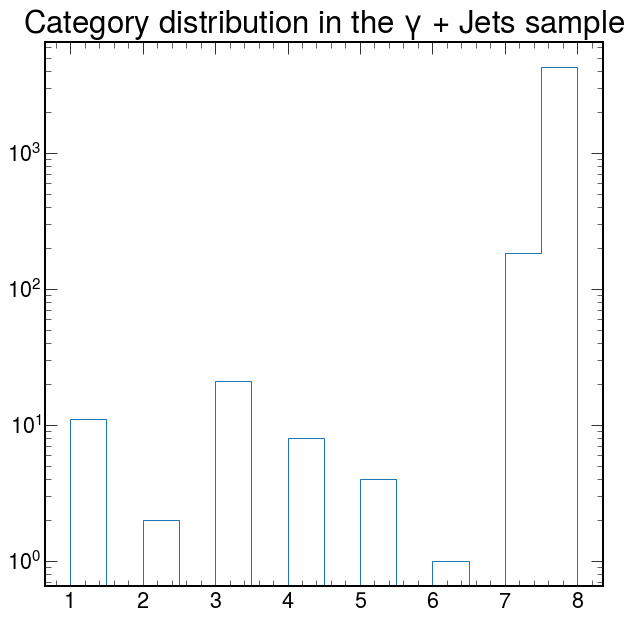

In [4]:
Hist1D(dfs.loc[dfs["process_id"] > 0, "Category"]).plot()
plt.yscale("log")
plt.title("Category distribution in the $\gamma$ + Jets sample")

So it's mostly Categories 7 and 8, which makes sense as faking two leptons is usually more rare than faking one 

# $\gamma$ + Jets background estimation

### Get the distribution of fake photon ID MVA from the GJets MC events

Assert that the photon that fails ID cuts is usually the fake one

In [5]:
# Get the number of events where the first photon is fake and the second photon is real, and the first photon has higher ID

print("Number of outliers = ", sum(dfs.loc[(dfs["g1_isFake"] == 1) & (dfs["g2_isFake"] == 0), "g1_idmva"] >= dfs.loc[(dfs["g1_isFake"] == 1) & (dfs["g2_isFake"] == 0), "g2_idmva"]))
print("number of events = ", len(dfs.loc[(dfs["g1_isFake"] == 1) & (dfs["g2_isFake"] == 0), "g1_idmva"]))

Number of outliers =  63
number of events =  1434


In [6]:
# Get the number of events where the second photon is fake and the first photon is real, and the second photon has higher ID

print("Number of outliers = ", sum(dfs.loc[(dfs["g1_isFake"] == 0) & (dfs["g2_isFake"] == 1), "g2_idmva"] >= dfs.loc[(dfs["g1_isFake"] == 0) & (dfs["g2_isFake"] == 1), "g1_idmva"]))
print("Number of events = ", len(dfs.loc[(dfs["g1_isFake"] == 0) & (dfs["g2_isFake"] == 1), "g2_idmva"]))

Number of outliers =  71
Number of events =  1952


In [7]:
(63 + 71) / (1434 + 1952)

0.039574719432959246

So approx 4\% outliers to our hypothesis - consistent with what Sam saw

Tangential conclusion - photon ID does not depend on lepton flavour (as expected)

Add real and fake photon ID MVA categories

In [8]:
Hist1D(dfs.loc[dfs["process_id"] > 0, "g1_isFake"] + dfs.loc[dfs["process_id"] > 0, "g2_isFake"], weights=dfs.loc[dfs["process_id"] > 0, "weight"])

[15421.31 ± 1055.09    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   62159.07 ± 2035.44
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
 214.47 ± 68.77]

In [9]:
Hist1D(dfs.loc[dfs["process_id"] > 0, "g1_isFake"] + dfs.loc[dfs["process_id"] > 0, "g2_isFake"], weights=dfs.loc[dfs["process_id"] > 0, "weight"])

[15421.31 ± 1055.09    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   62159.07 ± 2035.44
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
 214.47 ± 68.77]

In [10]:
dfs["n_fake_photons"] = ((dfs["g1_isFake"] + dfs["g2_isFake"]))
dfs["fake_photon_idmva"] = np.ones(len(dfs)) * -999
dfs["real_photon_idmva"] = np.ones(len(dfs)) * -999

dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "real_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "g2_idmva"]
dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "fake_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g1_isFake"] == 1), "g1_idmva"]

dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "real_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "g1_idmva"]
dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "fake_photon_idmva"] = dfs.loc[(dfs["n_fake_photons"] == 1) & (dfs["g2_isFake"] == 1), "g2_idmva"]

#### Correlation plots

In [11]:
def compute_correlation(v1, v2):
    return ((v1*v2).mean() - (v1.mean()) * (v2.mean())) / (v1.std() * v2.std())

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0.00556626949488751

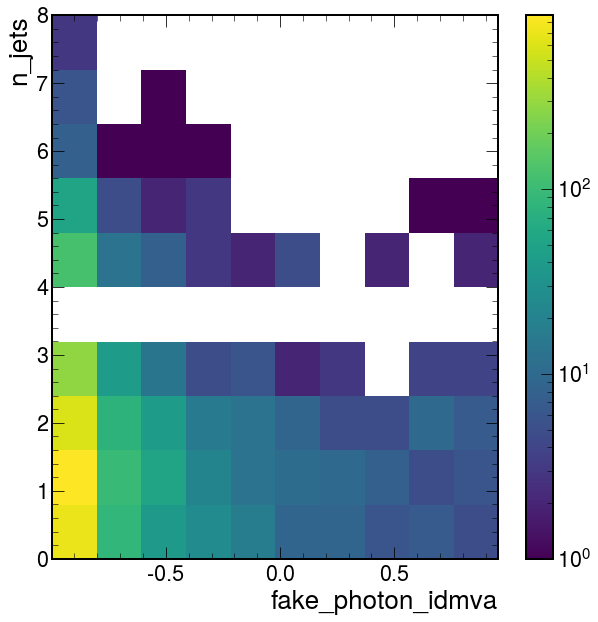

In [12]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "n_jets"]])
x.plot(logz=True)
plt.savefig("fake_id_v_n_jets.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "n_jets"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


-0.004121461879956882

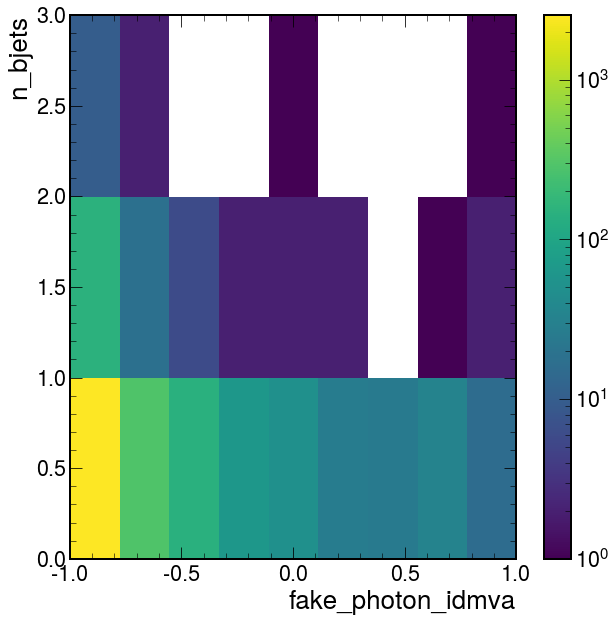

In [13]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "n_bjets"]], bins=(linspace(-1,1,10), arange(0,4,1)))
x.plot(logz=True)
plt.savefig("fake_id_v_n_bjets.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "n_bjets"])


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


-0.01885380846263155

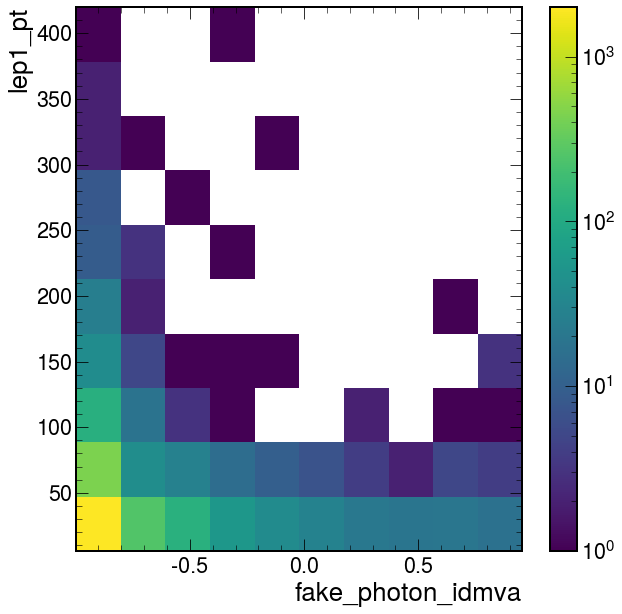

In [14]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "lep1_pt"]])
x.plot(logz=True)
plt.savefig("fake_id_v_lep_1_pt.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "lep1_pt"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0.003663435733167634

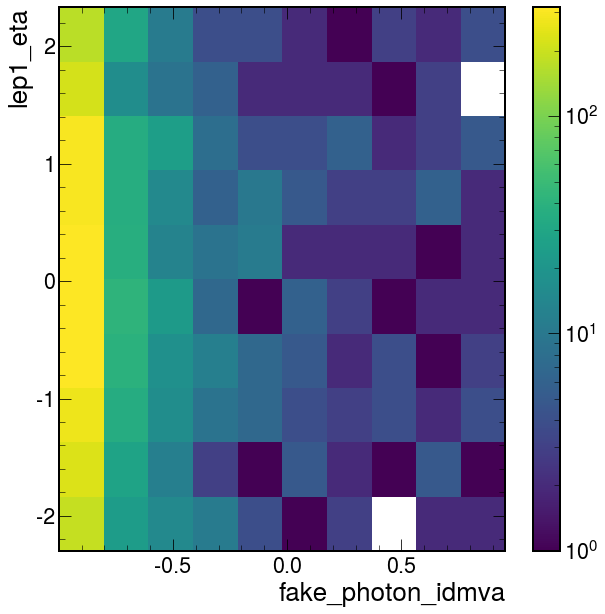

In [15]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), ["fake_photon_idmva", "lep1_eta"]])
x.plot(logz=True)
plt.savefig("fake_id_v_lep_1_eta.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "lep1_eta"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


-0.030147297397907568

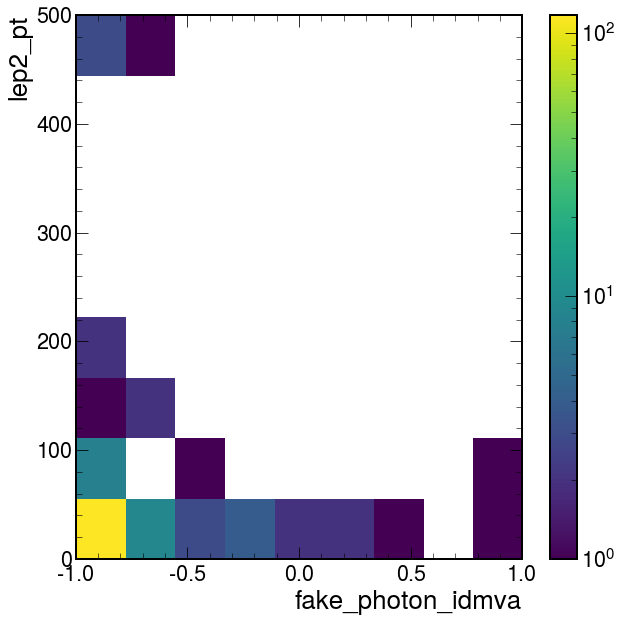

In [16]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), ["fake_photon_idmva", "lep2_pt"]], bins=(linspace(-1,1,10), linspace(0,500,10)))
x.plot(logz=True)
plt.savefig("fake_id_vs_lep_2_pt.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "lep2_pt"])

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


0.03421247461216695

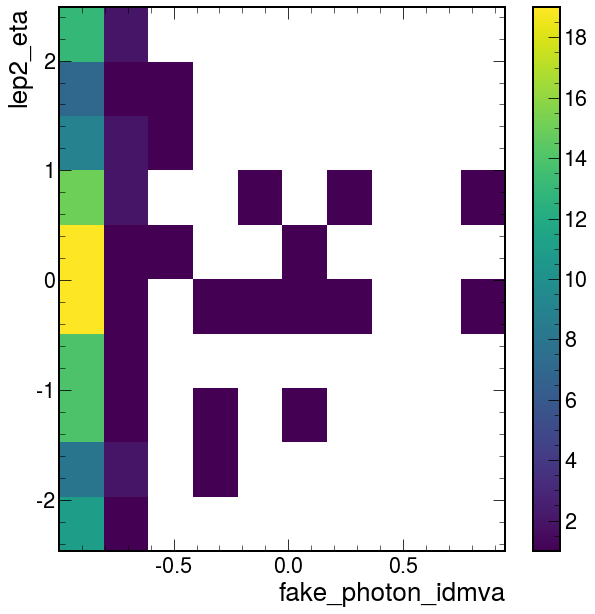

In [17]:
x = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), ["fake_photon_idmva", "lep2_eta"]])
x.plot()
plt.savefig("fake_id_vs_lep_2_eta.pdf")
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "fake_photon_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999) & (dfs["lep2_pt"] > 0), "lep2_eta"])

Given that we've established that the fake photon ID MVA is uncorrelated with the other variables, we can replace these in data with the sampled values without any issues

### Generating fake IDs

### Wild idea - To jack up statistics, we can maybe remove the $\tau$ lepton requirement while estimating the background and then normalize things back! (similar to $\kappa$ derivation for Z/Edge)

In [18]:
from scipy.stats import gaussian_kde

Let's use relatively fancy stuff like Gaussian KDEs

In [19]:
model = gaussian_kde(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], bw_method="silverman")

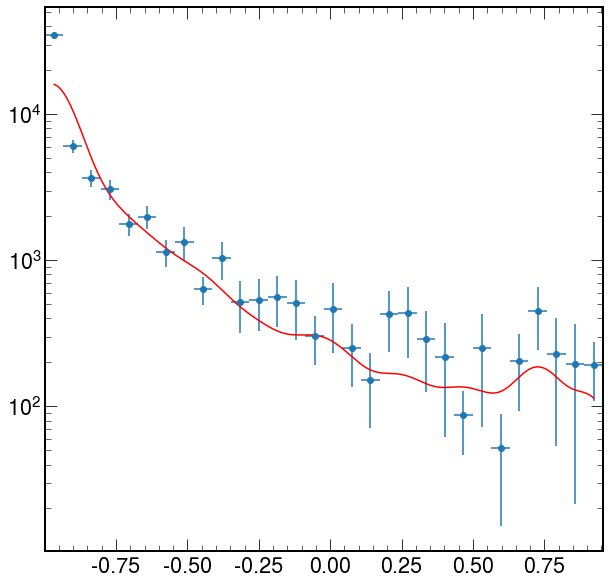

In [20]:
idHist = Hist1D(dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "fake_photon_idmva"], weights=dfs.loc[(dfs["process_id"] > 0) & (dfs["fake_photon_idmva"] > -999), "weight"], bins=30)
sample_points = linspace(min(idHist.bin_centers), max(idHist.bin_centers), 200)
pdf = model.pdf(sample_points) * idHist.integral * idHist.bin_widths[0]
idHist.plot(show_errors=True)
plt.plot(sample_points, pdf, "r")
plt.yscale("log")

In [21]:
dfs["max_gamma_idmva"] = np.ones(len(dfs)) * -999
dfs["min_gamma_idmva"] = np.ones(len(dfs)) * -999

dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "max_gamma_idmva"] = dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "g1_idmva"]
dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "min_gamma_idmva"] = dfs.loc[dfs["g1_idmva"] > dfs["g2_idmva"], "g2_idmva"]

dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "max_gamma_idmva"] = dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "g2_idmva"]
dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "min_gamma_idmva"] = dfs.loc[dfs["g2_idmva"] >= dfs["g1_idmva"], "g1_idmva"]

In [22]:
data_df = dfs.loc[dfs["process_id"] == 0].copy()
data_df["max_gamma_idmva"] = np.ones(len(data_df)) * -999
data_df["min_gamma_idmva"] = np.ones(len(data_df)) * -999

data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "max_gamma_idmva"] = data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "g1_idmva"]
data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "min_gamma_idmva"] = data_df.loc[data_df["g1_idmva"] > data_df["g2_idmva"], "g2_idmva"]

data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "max_gamma_idmva"] = data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "g2_idmva"]
data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "min_gamma_idmva"] = data_df.loc[data_df["g2_idmva"] >= data_df["g1_idmva"], "g1_idmva"]

Replace min_gamma_idmva with the sampled value for those events where min_gamma_idmva <= -0.7 and max_gamma_idmva > -0.7

## Analysis of yields from the "parent" sample without the lepton selections, and the "pre-selected" sample with lepton selections

In [23]:
f = uproot.open("../preliminaryNtuple_no_lepton_selection.root")
t = f["t"]

In [24]:
parentDF = t.arrays(library="pd")

Ultimately, we need to compare the yields after $\gamma$ selection

In [25]:
data_parentDF = parentDF.loc[parentDF["process_id"] == 0].copy()
data_parentDF["max_gamma_idmva"] = np.ones(len(data_parentDF)) * -999
data_parentDF["min_gamma_idmva"] = np.ones(len(data_parentDF)) * -999

data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "max_gamma_idmva"] = data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "g1_idmva"]
data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "min_gamma_idmva"] = data_parentDF.loc[data_parentDF["g1_idmva"] > data_parentDF["g2_idmva"], "g2_idmva"]

data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "max_gamma_idmva"] = data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "g2_idmva"]
data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "min_gamma_idmva"] = data_parentDF.loc[data_parentDF["g2_idmva"] >= data_parentDF["g1_idmva"], "g1_idmva"]

In [26]:
parentDF

,MET_dil_dphi,n_taus,n_electrons,jet2_id,lep12_dphi,jet2_bTag,gg_eta,tt_hel_vis,jet2_eta_bdt,MET_pt,...,g1_ptmgg,pt_tautau_SVFit,g2_pixVeto,lep12_dR,MET_phi,lep1_charge,gg_tt_hel_vis,eta_tautau_SVFit,eta_bdt_tautau_SVFit,phi_tautau_SVFit
0,-0.719360,0.0,0.0,-999.0,0.0,-999.000000,2.580260,1.0,-999.000000,38.080658,...,0.461614,0.000000,0.0,0.0,0.719360,-999.0,4.371139e-08,0.0,0.0,0.000000
1,-1.005127,0.0,0.0,-999.0,0.0,-999.000000,3.696579,1.0,-999.000000,16.149218,...,0.463273,0.000000,0.0,0.0,1.005127,-999.0,4.371139e-08,0.0,0.0,0.000000
2,-0.112823,0.0,0.0,-999.0,0.0,-999.000000,2.995089,1.0,-999.000000,30.793530,...,0.437107,0.000000,0.0,0.0,0.112823,-999.0,4.371139e-08,0.0,0.0,0.000000
3,-1.584473,0.0,0.0,-999.0,0.0,-999.000000,0.579111,1.0,-999.000000,27.345707,...,0.496964,0.000000,0.0,0.0,1.584473,-999.0,4.371139e-08,0.0,0.0,0.000000
4,2.554199,0.0,0.0,7.0,0.0,0.035828,-1.354119,1.0,-2.072754,39.672356,...,0.544012,0.000000,0.0,0.0,-2.554199,-999.0,4.371139e-08,0.0,-0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19843293,-3.002687,0.0,0.0,6.0,0.0,0.006939,1.859221,1.0,1.132812,36.882896,...,0.445988,1333.333374,0.0,0.0,-0.112442,-999.0,4.371139e-08,inf,inf,-3.115129
19843294,-999.000000,1.0,0.0,-999.0,-999.0,-999.000000,-0.253674,-999.0,-999.000000,40.611900,...,0.832809,-999.000000,0.0,-999.0,1.617920,1.0,-9.990000e+02,-999.0,-999.0,-999.000000
19843295,0.017684,0.0,0.0,-999.0,0.0,-999.000000,-2.070966,1.0,-999.000000,26.442757,...,0.697627,1333.333374,0.0,0.0,-3.132812,-999.0,4.371139e-08,inf,-inf,-3.115129
19843296,1.138272,0.0,0.0,6.0,0.0,0.005455,-2.368446,1.0,-1.220947,30.029984,...,1.198723,1333.333374,0.0,0.0,2.029785,-999.0,4.371139e-08,inf,-inf,-3.115129


In [27]:
parentDF["n_fake_photons"] = ((parentDF["g1_isFake"] + parentDF["g2_isFake"]))
parentDF["fake_photon_idmva"] = np.ones(len(parentDF)) * -999
parentDF["real_photon_idmva"] = np.ones(len(parentDF)) * -999

parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "real_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "g2_idmva"]
parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "fake_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g1_isFake"] == 1), "g1_idmva"]

parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "real_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "g1_idmva"]
parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "fake_photon_idmva"] = parentDF.loc[(parentDF["n_fake_photons"] == 1) & (parentDF["g2_isFake"] == 1), "g2_idmva"]

In [28]:
model = gaussian_kde(parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "fake_photon_idmva"], bw_method="silverman", weights= abs(parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "weight"]))

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


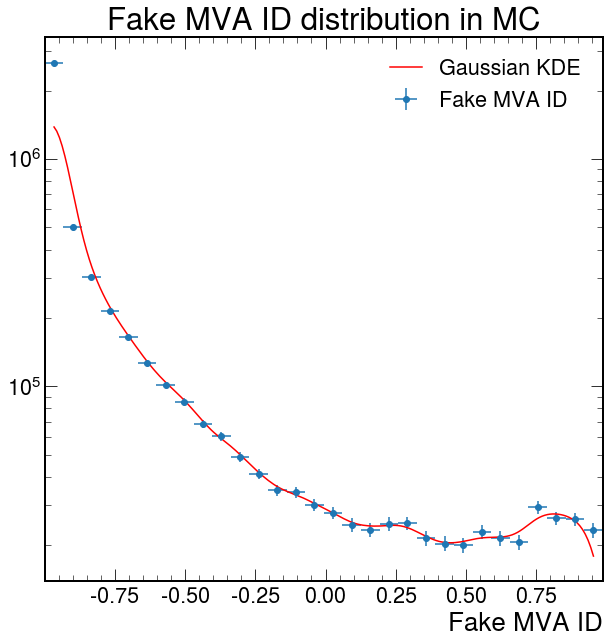

In [29]:
idHist = Hist1D(parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "fake_photon_idmva"], weights=parentDF.loc[(parentDF["process_id"] > 0) & (parentDF["fake_photon_idmva"] > -999), "weight"], bins=30)
idHist.plot(show_errors=True, label="Fake MVA ID")
sample_points = linspace(min(idHist.bin_centers), max(idHist.bin_centers), 200)
pdf = model.pdf(sample_points) * idHist.integral * idHist.bin_widths[0]
plt.plot(sample_points, pdf, "r", label="Gaussian KDE")
plt.yscale("log")
plt.xlabel("Fake MVA ID")
plt.legend()
plt.title("Fake MVA ID distribution in MC")
plt.savefig("fake_mva_id_mc_distribution_inclusive.pdf")

### Sample from the new distribution!

First things first, check if real $\gamma$ MVA ID and fake $\gamma$ MVA ID are correlated

In [30]:
tempHist = Hist2D(dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), ["g1_idmva", "g2_idmva"]], weights=dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), "weight"])

In [31]:
tempHist.correlation()

-0.10512336728502826

In [32]:
dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), ["g1_idmva", "g2_idmva"]]
compute_correlation(dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), "g1_idmva"], dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > -0.7) & (dfs["g2_idmva"] > -0.7), "g2_idmva"])

-0.0916175

**Sample from photon ID distribution. Don't bound it upwards (Leonardo's idea)**

In [33]:
dfs.columns

Index(['dPhi_ggtautau_SVFit', 'n_taus', 'n_electrons', 'jet2_id', 'lep12_dphi',
       'jet2_bTag', 'gg_eta', 'tt_hel_vis', 'jet2_eta_bdt', 'MET_pt',
       ...
       'gg_tt_hel_vis', 'eta_tautau_SVFit', 'eta_bdt_tautau_SVFit',
       'phi_tautau_SVFit', 'MET_dil_dphi', 'n_fake_photons',
       'fake_photon_idmva', 'real_photon_idmva', 'max_gamma_idmva',
       'min_gamma_idmva'],
      dtype='object', length=103)

In [34]:
data_df["min_gamma_idmva_sim"] = np.ones(len(data_df)) * -999

while not all(data_df["min_gamma_idmva_sim"] > -0.7):
    data_df.loc[data_df["min_gamma_idmva_sim"] <= -0.7, "min_gamma_idmva_sim"] = model.resample(len(data_df.loc[data_df["min_gamma_idmva_sim"] <= -0.7]))[0]

Compare distributions of max $\gamma$ ID MVA in MC (both max and min > 0.7) and data (max > 0.7, min < 0.7)

In [35]:
mcHist = Hist1D(dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > 0.7) & (dfs["g2_idmva"] > 0.7), "max_gamma_idmva"], weights=dfs.loc[(dfs["process_id"] > 0) & (dfs["g1_idmva"] > 0.7) & (dfs["g2_idmva"] > 0.7), "weight"], bins="30,0.7,1")
dataHist = Hist1D(data_df.loc[(data_df["max_gamma_idmva"] > 0.7) & (data_df["min_gamma_idmva"] <= 0.7), "max_gamma_idmva"], bins="30,0.7,1")

<AxesSubplot:>

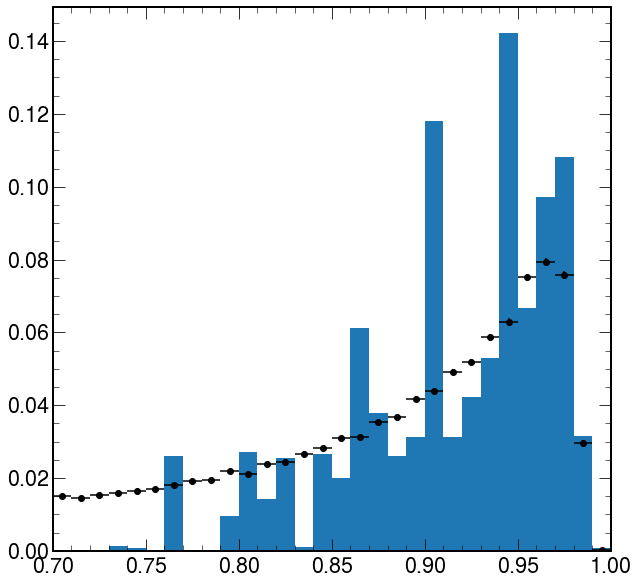

In [37]:
mcHist /= mcHist.integral
dataHist /= dataHist.integral

mcHist.plot(histtype="stepfilled")
dataHist.plot(show_errors = True, color="k")

Reproducing the AN now, with sampling only till max

In [38]:
counter = 0
lengths = []
data_df["min_gamma_idmva_sim_AN"] = np.ones(len(data_df)) * -999
background_df = data_df.loc[(data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7)]
while not (all(data_df.loc[(data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7), "min_gamma_idmva_sim_AN"] < data_df.loc[(data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7), "max_gamma_idmva"]) and all(data_df.loc[(data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7), "min_gamma_idmva_sim_AN"] > -0.7)):
    length = len(data_df.loc[((data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7)) & (data_df["min_gamma_idmva_sim_AN"] < -0.7) | (data_df["min_gamma_idmva_sim_AN"] >= data_df["max_gamma_idmva"]), "min_gamma_idmva_sim_AN"])
    lengths.append(length)
    counter += 1
    print("iteration = {} current length = {}".format(counter, length))
    data_df.loc[((data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7)) & (data_df["min_gamma_idmva_sim_AN"] < -0.7) | (data_df["min_gamma_idmva_sim_AN"] >= data_df["max_gamma_idmva"]), "min_gamma_idmva_sim_AN"] = model.resample(length)[0]
    

iteration = 1 current length = 130728
iteration = 2 current length = 109453
iteration = 3 current length = 92411
iteration = 4 current length = 78503
iteration = 5 current length = 67093
iteration = 6 current length = 57768
iteration = 7 current length = 50037
iteration = 8 current length = 43607
iteration = 9 current length = 38388
iteration = 10 current length = 33995
iteration = 11 current length = 30356
iteration = 12 current length = 27309
iteration = 13 current length = 24713
iteration = 14 current length = 22552
iteration = 15 current length = 20655
iteration = 16 current length = 19052
iteration = 17 current length = 17604
iteration = 18 current length = 16411
iteration = 19 current length = 15357
iteration = 20 current length = 14381
iteration = 21 current length = 13614
iteration = 22 current length = 12873
iteration = 23 current length = 12200
iteration = 24 current length = 11588
iteration = 25 current length = 11033
iteration = 26 current length = 10530
iteration = 27 curr

iteration = 221 current length = 1143
iteration = 222 current length = 1134
iteration = 223 current length = 1128
iteration = 224 current length = 1123
iteration = 225 current length = 1118
iteration = 226 current length = 1113
iteration = 227 current length = 1108
iteration = 228 current length = 1100
iteration = 229 current length = 1093
iteration = 230 current length = 1089
iteration = 231 current length = 1087
iteration = 232 current length = 1081
iteration = 233 current length = 1078
iteration = 234 current length = 1075
iteration = 235 current length = 1071
iteration = 236 current length = 1069
iteration = 237 current length = 1064
iteration = 238 current length = 1052
iteration = 239 current length = 1048
iteration = 240 current length = 1045
iteration = 241 current length = 1043
iteration = 242 current length = 1039
iteration = 243 current length = 1032
iteration = 244 current length = 1024
iteration = 245 current length = 1021
iteration = 246 current length = 1013
iteration = 

iteration = 451 current length = 526
iteration = 452 current length = 525
iteration = 453 current length = 525
iteration = 454 current length = 524
iteration = 455 current length = 524
iteration = 456 current length = 523
iteration = 457 current length = 523
iteration = 458 current length = 520
iteration = 459 current length = 519
iteration = 460 current length = 517
iteration = 461 current length = 517
iteration = 462 current length = 514
iteration = 463 current length = 514
iteration = 464 current length = 514
iteration = 465 current length = 512
iteration = 466 current length = 510
iteration = 467 current length = 508
iteration = 468 current length = 507
iteration = 469 current length = 504
iteration = 470 current length = 503
iteration = 471 current length = 502
iteration = 472 current length = 502
iteration = 473 current length = 500
iteration = 474 current length = 497
iteration = 475 current length = 496
iteration = 476 current length = 496
iteration = 477 current length = 494
i

iteration = 681 current length = 355
iteration = 682 current length = 355
iteration = 683 current length = 355
iteration = 684 current length = 354
iteration = 685 current length = 353
iteration = 686 current length = 353
iteration = 687 current length = 352
iteration = 688 current length = 351
iteration = 689 current length = 351
iteration = 690 current length = 349
iteration = 691 current length = 349
iteration = 692 current length = 346
iteration = 693 current length = 345
iteration = 694 current length = 344
iteration = 695 current length = 343
iteration = 696 current length = 342
iteration = 697 current length = 342
iteration = 698 current length = 340
iteration = 699 current length = 340
iteration = 700 current length = 339
iteration = 701 current length = 339
iteration = 702 current length = 336
iteration = 703 current length = 336
iteration = 704 current length = 336
iteration = 705 current length = 336
iteration = 706 current length = 335
iteration = 707 current length = 334
i

iteration = 911 current length = 265
iteration = 912 current length = 265
iteration = 913 current length = 265
iteration = 914 current length = 265
iteration = 915 current length = 265
iteration = 916 current length = 265
iteration = 917 current length = 265
iteration = 918 current length = 264
iteration = 919 current length = 264
iteration = 920 current length = 263
iteration = 921 current length = 263
iteration = 922 current length = 263
iteration = 923 current length = 263
iteration = 924 current length = 263
iteration = 925 current length = 263
iteration = 926 current length = 263
iteration = 927 current length = 263
iteration = 928 current length = 263
iteration = 929 current length = 263
iteration = 930 current length = 262
iteration = 931 current length = 262
iteration = 932 current length = 262
iteration = 933 current length = 262
iteration = 934 current length = 261
iteration = 935 current length = 260
iteration = 936 current length = 260
iteration = 937 current length = 260
i

iteration = 1131 current length = 216
iteration = 1132 current length = 216
iteration = 1133 current length = 214
iteration = 1134 current length = 214
iteration = 1135 current length = 213
iteration = 1136 current length = 213
iteration = 1137 current length = 213
iteration = 1138 current length = 211
iteration = 1139 current length = 211
iteration = 1140 current length = 211
iteration = 1141 current length = 210
iteration = 1142 current length = 210
iteration = 1143 current length = 209
iteration = 1144 current length = 209
iteration = 1145 current length = 209
iteration = 1146 current length = 209
iteration = 1147 current length = 209
iteration = 1148 current length = 209
iteration = 1149 current length = 209
iteration = 1150 current length = 207
iteration = 1151 current length = 207
iteration = 1152 current length = 207
iteration = 1153 current length = 207
iteration = 1154 current length = 207
iteration = 1155 current length = 207
iteration = 1156 current length = 207
iteration = 

iteration = 1351 current length = 168
iteration = 1352 current length = 168
iteration = 1353 current length = 168
iteration = 1354 current length = 168
iteration = 1355 current length = 168
iteration = 1356 current length = 167
iteration = 1357 current length = 166
iteration = 1358 current length = 166
iteration = 1359 current length = 165
iteration = 1360 current length = 165
iteration = 1361 current length = 165
iteration = 1362 current length = 165
iteration = 1363 current length = 165
iteration = 1364 current length = 165
iteration = 1365 current length = 165
iteration = 1366 current length = 165
iteration = 1367 current length = 165
iteration = 1368 current length = 165
iteration = 1369 current length = 165
iteration = 1370 current length = 165
iteration = 1371 current length = 165
iteration = 1372 current length = 165
iteration = 1373 current length = 165
iteration = 1374 current length = 165
iteration = 1375 current length = 165
iteration = 1376 current length = 165
iteration = 

iteration = 1571 current length = 138
iteration = 1572 current length = 138
iteration = 1573 current length = 138
iteration = 1574 current length = 138
iteration = 1575 current length = 138
iteration = 1576 current length = 138
iteration = 1577 current length = 138
iteration = 1578 current length = 137
iteration = 1579 current length = 137
iteration = 1580 current length = 137
iteration = 1581 current length = 137
iteration = 1582 current length = 137
iteration = 1583 current length = 137
iteration = 1584 current length = 137
iteration = 1585 current length = 137
iteration = 1586 current length = 137
iteration = 1587 current length = 137
iteration = 1588 current length = 137
iteration = 1589 current length = 137
iteration = 1590 current length = 137
iteration = 1591 current length = 137
iteration = 1592 current length = 137
iteration = 1593 current length = 137
iteration = 1594 current length = 137
iteration = 1595 current length = 137
iteration = 1596 current length = 137
iteration = 

iteration = 1791 current length = 127
iteration = 1792 current length = 127
iteration = 1793 current length = 127
iteration = 1794 current length = 127
iteration = 1795 current length = 127
iteration = 1796 current length = 127
iteration = 1797 current length = 127
iteration = 1798 current length = 127
iteration = 1799 current length = 127
iteration = 1800 current length = 127
iteration = 1801 current length = 127
iteration = 1802 current length = 127
iteration = 1803 current length = 127
iteration = 1804 current length = 127
iteration = 1805 current length = 126
iteration = 1806 current length = 126
iteration = 1807 current length = 126
iteration = 1808 current length = 126
iteration = 1809 current length = 126
iteration = 1810 current length = 125
iteration = 1811 current length = 124
iteration = 1812 current length = 124
iteration = 1813 current length = 124
iteration = 1814 current length = 124
iteration = 1815 current length = 124
iteration = 1816 current length = 124
iteration = 

iteration = 2011 current length = 112
iteration = 2012 current length = 112
iteration = 2013 current length = 112
iteration = 2014 current length = 112
iteration = 2015 current length = 112
iteration = 2016 current length = 110
iteration = 2017 current length = 110
iteration = 2018 current length = 110
iteration = 2019 current length = 109
iteration = 2020 current length = 109
iteration = 2021 current length = 109
iteration = 2022 current length = 109
iteration = 2023 current length = 109
iteration = 2024 current length = 109
iteration = 2025 current length = 109
iteration = 2026 current length = 109
iteration = 2027 current length = 109
iteration = 2028 current length = 109
iteration = 2029 current length = 109
iteration = 2030 current length = 109
iteration = 2031 current length = 109
iteration = 2032 current length = 109
iteration = 2033 current length = 109
iteration = 2034 current length = 109
iteration = 2035 current length = 109
iteration = 2036 current length = 109
iteration = 

iteration = 2231 current length = 102
iteration = 2232 current length = 102
iteration = 2233 current length = 102
iteration = 2234 current length = 102
iteration = 2235 current length = 102
iteration = 2236 current length = 102
iteration = 2237 current length = 102
iteration = 2238 current length = 102
iteration = 2239 current length = 102
iteration = 2240 current length = 102
iteration = 2241 current length = 102
iteration = 2242 current length = 102
iteration = 2243 current length = 102
iteration = 2244 current length = 102
iteration = 2245 current length = 102
iteration = 2246 current length = 102
iteration = 2247 current length = 102
iteration = 2248 current length = 101
iteration = 2249 current length = 101
iteration = 2250 current length = 101
iteration = 2251 current length = 101
iteration = 2252 current length = 100
iteration = 2253 current length = 100
iteration = 2254 current length = 100
iteration = 2255 current length = 100
iteration = 2256 current length = 100
iteration = 

iteration = 2461 current length = 94
iteration = 2462 current length = 94
iteration = 2463 current length = 94
iteration = 2464 current length = 94
iteration = 2465 current length = 94
iteration = 2466 current length = 94
iteration = 2467 current length = 94
iteration = 2468 current length = 94
iteration = 2469 current length = 94
iteration = 2470 current length = 94
iteration = 2471 current length = 94
iteration = 2472 current length = 94
iteration = 2473 current length = 94
iteration = 2474 current length = 94
iteration = 2475 current length = 94
iteration = 2476 current length = 94
iteration = 2477 current length = 94
iteration = 2478 current length = 94
iteration = 2479 current length = 94
iteration = 2480 current length = 94
iteration = 2481 current length = 94
iteration = 2482 current length = 94
iteration = 2483 current length = 94
iteration = 2484 current length = 94
iteration = 2485 current length = 94
iteration = 2486 current length = 94
iteration = 2487 current length = 94
i

iteration = 2691 current length = 85
iteration = 2692 current length = 85
iteration = 2693 current length = 84
iteration = 2694 current length = 84
iteration = 2695 current length = 84
iteration = 2696 current length = 84
iteration = 2697 current length = 84
iteration = 2698 current length = 84
iteration = 2699 current length = 84
iteration = 2700 current length = 84
iteration = 2701 current length = 84
iteration = 2702 current length = 84
iteration = 2703 current length = 84
iteration = 2704 current length = 84
iteration = 2705 current length = 84
iteration = 2706 current length = 84
iteration = 2707 current length = 84
iteration = 2708 current length = 84
iteration = 2709 current length = 84
iteration = 2710 current length = 84
iteration = 2711 current length = 84
iteration = 2712 current length = 84
iteration = 2713 current length = 83
iteration = 2714 current length = 83
iteration = 2715 current length = 83
iteration = 2716 current length = 83
iteration = 2717 current length = 82
i

iteration = 2921 current length = 71
iteration = 2922 current length = 71
iteration = 2923 current length = 71
iteration = 2924 current length = 71
iteration = 2925 current length = 71
iteration = 2926 current length = 71
iteration = 2927 current length = 71
iteration = 2928 current length = 71
iteration = 2929 current length = 71
iteration = 2930 current length = 71
iteration = 2931 current length = 71
iteration = 2932 current length = 71
iteration = 2933 current length = 71
iteration = 2934 current length = 71
iteration = 2935 current length = 71
iteration = 2936 current length = 71
iteration = 2937 current length = 71
iteration = 2938 current length = 71
iteration = 2939 current length = 71
iteration = 2940 current length = 71
iteration = 2941 current length = 71
iteration = 2942 current length = 71
iteration = 2943 current length = 71
iteration = 2944 current length = 71
iteration = 2945 current length = 71
iteration = 2946 current length = 71
iteration = 2947 current length = 71
i

iteration = 3151 current length = 69
iteration = 3152 current length = 69
iteration = 3153 current length = 69
iteration = 3154 current length = 69
iteration = 3155 current length = 69
iteration = 3156 current length = 69
iteration = 3157 current length = 69
iteration = 3158 current length = 69
iteration = 3159 current length = 69
iteration = 3160 current length = 68
iteration = 3161 current length = 68
iteration = 3162 current length = 68
iteration = 3163 current length = 68
iteration = 3164 current length = 68
iteration = 3165 current length = 68
iteration = 3166 current length = 68
iteration = 3167 current length = 68
iteration = 3168 current length = 68
iteration = 3169 current length = 68
iteration = 3170 current length = 68
iteration = 3171 current length = 68
iteration = 3172 current length = 68
iteration = 3173 current length = 68
iteration = 3174 current length = 68
iteration = 3175 current length = 68
iteration = 3176 current length = 68
iteration = 3177 current length = 68
i

iteration = 3381 current length = 62
iteration = 3382 current length = 62
iteration = 3383 current length = 62
iteration = 3384 current length = 62
iteration = 3385 current length = 62
iteration = 3386 current length = 61
iteration = 3387 current length = 61
iteration = 3388 current length = 61
iteration = 3389 current length = 61
iteration = 3390 current length = 61
iteration = 3391 current length = 61
iteration = 3392 current length = 61
iteration = 3393 current length = 61
iteration = 3394 current length = 61
iteration = 3395 current length = 61
iteration = 3396 current length = 61
iteration = 3397 current length = 61
iteration = 3398 current length = 61
iteration = 3399 current length = 61
iteration = 3400 current length = 61
iteration = 3401 current length = 61
iteration = 3402 current length = 61
iteration = 3403 current length = 61
iteration = 3404 current length = 61
iteration = 3405 current length = 61
iteration = 3406 current length = 61
iteration = 3407 current length = 61
i

iteration = 3611 current length = 59
iteration = 3612 current length = 59
iteration = 3613 current length = 59
iteration = 3614 current length = 59
iteration = 3615 current length = 59
iteration = 3616 current length = 59
iteration = 3617 current length = 59
iteration = 3618 current length = 59
iteration = 3619 current length = 59
iteration = 3620 current length = 59
iteration = 3621 current length = 59
iteration = 3622 current length = 59
iteration = 3623 current length = 59
iteration = 3624 current length = 59
iteration = 3625 current length = 59
iteration = 3626 current length = 59
iteration = 3627 current length = 59
iteration = 3628 current length = 59
iteration = 3629 current length = 59
iteration = 3630 current length = 59
iteration = 3631 current length = 59
iteration = 3632 current length = 59
iteration = 3633 current length = 59
iteration = 3634 current length = 59
iteration = 3635 current length = 59
iteration = 3636 current length = 59
iteration = 3637 current length = 59
i

iteration = 3841 current length = 54
iteration = 3842 current length = 54
iteration = 3843 current length = 54
iteration = 3844 current length = 54
iteration = 3845 current length = 54
iteration = 3846 current length = 54
iteration = 3847 current length = 54
iteration = 3848 current length = 54
iteration = 3849 current length = 54
iteration = 3850 current length = 54
iteration = 3851 current length = 54
iteration = 3852 current length = 54
iteration = 3853 current length = 54
iteration = 3854 current length = 54
iteration = 3855 current length = 54
iteration = 3856 current length = 54
iteration = 3857 current length = 54
iteration = 3858 current length = 54
iteration = 3859 current length = 54
iteration = 3860 current length = 54
iteration = 3861 current length = 53
iteration = 3862 current length = 53
iteration = 3863 current length = 53
iteration = 3864 current length = 53
iteration = 3865 current length = 53
iteration = 3866 current length = 53
iteration = 3867 current length = 53
i

iteration = 4071 current length = 47
iteration = 4072 current length = 47
iteration = 4073 current length = 47
iteration = 4074 current length = 47
iteration = 4075 current length = 47
iteration = 4076 current length = 47
iteration = 4077 current length = 47
iteration = 4078 current length = 47
iteration = 4079 current length = 47
iteration = 4080 current length = 47
iteration = 4081 current length = 47
iteration = 4082 current length = 47
iteration = 4083 current length = 47
iteration = 4084 current length = 47
iteration = 4085 current length = 47
iteration = 4086 current length = 47
iteration = 4087 current length = 47
iteration = 4088 current length = 47
iteration = 4089 current length = 47
iteration = 4090 current length = 47
iteration = 4091 current length = 47
iteration = 4092 current length = 47
iteration = 4093 current length = 47
iteration = 4094 current length = 47
iteration = 4095 current length = 47
iteration = 4096 current length = 47
iteration = 4097 current length = 47
i

iteration = 4300 current length = 44
iteration = 4301 current length = 44
iteration = 4302 current length = 44
iteration = 4303 current length = 44
iteration = 4304 current length = 44
iteration = 4305 current length = 44
iteration = 4306 current length = 44
iteration = 4307 current length = 44
iteration = 4308 current length = 44
iteration = 4309 current length = 44
iteration = 4310 current length = 44
iteration = 4311 current length = 44
iteration = 4312 current length = 44
iteration = 4313 current length = 44
iteration = 4314 current length = 44
iteration = 4315 current length = 44
iteration = 4316 current length = 44
iteration = 4317 current length = 44
iteration = 4318 current length = 44
iteration = 4319 current length = 44
iteration = 4320 current length = 44
iteration = 4321 current length = 44
iteration = 4322 current length = 44
iteration = 4323 current length = 44
iteration = 4324 current length = 44
iteration = 4325 current length = 44
iteration = 4326 current length = 44
i

iteration = 4530 current length = 43
iteration = 4531 current length = 43
iteration = 4532 current length = 43
iteration = 4533 current length = 43
iteration = 4534 current length = 43
iteration = 4535 current length = 43
iteration = 4536 current length = 43
iteration = 4537 current length = 43
iteration = 4538 current length = 43
iteration = 4539 current length = 43
iteration = 4540 current length = 43
iteration = 4541 current length = 43
iteration = 4542 current length = 43
iteration = 4543 current length = 43
iteration = 4544 current length = 43
iteration = 4545 current length = 43
iteration = 4546 current length = 43
iteration = 4547 current length = 43
iteration = 4548 current length = 43
iteration = 4549 current length = 43
iteration = 4550 current length = 43
iteration = 4551 current length = 43
iteration = 4552 current length = 43
iteration = 4553 current length = 43
iteration = 4554 current length = 43
iteration = 4555 current length = 43
iteration = 4556 current length = 43
i

iteration = 4760 current length = 40
iteration = 4761 current length = 40
iteration = 4762 current length = 40
iteration = 4763 current length = 40
iteration = 4764 current length = 40
iteration = 4765 current length = 40
iteration = 4766 current length = 40
iteration = 4767 current length = 40
iteration = 4768 current length = 40
iteration = 4769 current length = 40
iteration = 4770 current length = 40
iteration = 4771 current length = 40
iteration = 4772 current length = 40
iteration = 4773 current length = 40
iteration = 4774 current length = 40
iteration = 4775 current length = 40
iteration = 4776 current length = 40
iteration = 4777 current length = 40
iteration = 4778 current length = 40
iteration = 4779 current length = 40
iteration = 4780 current length = 40
iteration = 4781 current length = 40
iteration = 4782 current length = 40
iteration = 4783 current length = 40
iteration = 4784 current length = 40
iteration = 4785 current length = 40
iteration = 4786 current length = 40
i

iteration = 4987 current length = 36
iteration = 4988 current length = 36
iteration = 4989 current length = 36
iteration = 4990 current length = 36
iteration = 4991 current length = 36
iteration = 4992 current length = 36
iteration = 4993 current length = 36
iteration = 4994 current length = 36
iteration = 4995 current length = 36
iteration = 4996 current length = 36
iteration = 4997 current length = 36
iteration = 4998 current length = 36
iteration = 4999 current length = 36
iteration = 5000 current length = 36
iteration = 5001 current length = 36
iteration = 5002 current length = 36
iteration = 5003 current length = 36
iteration = 5004 current length = 35
iteration = 5005 current length = 35
iteration = 5006 current length = 35
iteration = 5007 current length = 35
iteration = 5008 current length = 35
iteration = 5009 current length = 35
iteration = 5010 current length = 35
iteration = 5011 current length = 35
iteration = 5012 current length = 35
iteration = 5013 current length = 35
i

iteration = 5214 current length = 34
iteration = 5215 current length = 34
iteration = 5216 current length = 34
iteration = 5217 current length = 34
iteration = 5218 current length = 34
iteration = 5219 current length = 34
iteration = 5220 current length = 34
iteration = 5221 current length = 34
iteration = 5222 current length = 34
iteration = 5223 current length = 34
iteration = 5224 current length = 34
iteration = 5225 current length = 34
iteration = 5226 current length = 34
iteration = 5227 current length = 34
iteration = 5228 current length = 34
iteration = 5229 current length = 34
iteration = 5230 current length = 34
iteration = 5231 current length = 34
iteration = 5232 current length = 34
iteration = 5233 current length = 34
iteration = 5234 current length = 34
iteration = 5235 current length = 34
iteration = 5236 current length = 34
iteration = 5237 current length = 34
iteration = 5238 current length = 34
iteration = 5239 current length = 34
iteration = 5240 current length = 34
i

iteration = 5444 current length = 31
iteration = 5445 current length = 31
iteration = 5446 current length = 31
iteration = 5447 current length = 31
iteration = 5448 current length = 31
iteration = 5449 current length = 31
iteration = 5450 current length = 31
iteration = 5451 current length = 31
iteration = 5452 current length = 31
iteration = 5453 current length = 31
iteration = 5454 current length = 31
iteration = 5455 current length = 31
iteration = 5456 current length = 31
iteration = 5457 current length = 31
iteration = 5458 current length = 31
iteration = 5459 current length = 31
iteration = 5460 current length = 31
iteration = 5461 current length = 31
iteration = 5462 current length = 31
iteration = 5463 current length = 31
iteration = 5464 current length = 31
iteration = 5465 current length = 31
iteration = 5466 current length = 31
iteration = 5467 current length = 31
iteration = 5468 current length = 31
iteration = 5469 current length = 31
iteration = 5470 current length = 31
i

iteration = 5672 current length = 29
iteration = 5673 current length = 29
iteration = 5674 current length = 29
iteration = 5675 current length = 29
iteration = 5676 current length = 29
iteration = 5677 current length = 29
iteration = 5678 current length = 29
iteration = 5679 current length = 29
iteration = 5680 current length = 29
iteration = 5681 current length = 29
iteration = 5682 current length = 29
iteration = 5683 current length = 29
iteration = 5684 current length = 29
iteration = 5685 current length = 29
iteration = 5686 current length = 29
iteration = 5687 current length = 29
iteration = 5688 current length = 29
iteration = 5689 current length = 29
iteration = 5690 current length = 29
iteration = 5691 current length = 29
iteration = 5692 current length = 29
iteration = 5693 current length = 29
iteration = 5694 current length = 29
iteration = 5695 current length = 29
iteration = 5696 current length = 29
iteration = 5697 current length = 28
iteration = 5698 current length = 28
i

iteration = 5901 current length = 28
iteration = 5902 current length = 28
iteration = 5903 current length = 28
iteration = 5904 current length = 28
iteration = 5905 current length = 28
iteration = 5906 current length = 28
iteration = 5907 current length = 28
iteration = 5908 current length = 28
iteration = 5909 current length = 28
iteration = 5910 current length = 28
iteration = 5911 current length = 28
iteration = 5912 current length = 28
iteration = 5913 current length = 28
iteration = 5914 current length = 28
iteration = 5915 current length = 28
iteration = 5916 current length = 28
iteration = 5917 current length = 28
iteration = 5918 current length = 28
iteration = 5919 current length = 28
iteration = 5920 current length = 28
iteration = 5921 current length = 28
iteration = 5922 current length = 28
iteration = 5923 current length = 28
iteration = 5924 current length = 28
iteration = 5925 current length = 28
iteration = 5926 current length = 28
iteration = 5927 current length = 28
i

iteration = 6131 current length = 26
iteration = 6132 current length = 26
iteration = 6133 current length = 26
iteration = 6134 current length = 26
iteration = 6135 current length = 26
iteration = 6136 current length = 26
iteration = 6137 current length = 26
iteration = 6138 current length = 26
iteration = 6139 current length = 26
iteration = 6140 current length = 26
iteration = 6141 current length = 26
iteration = 6142 current length = 26
iteration = 6143 current length = 26
iteration = 6144 current length = 26
iteration = 6145 current length = 26
iteration = 6146 current length = 26
iteration = 6147 current length = 26
iteration = 6148 current length = 26
iteration = 6149 current length = 26
iteration = 6150 current length = 26
iteration = 6151 current length = 26
iteration = 6152 current length = 26
iteration = 6153 current length = 26
iteration = 6154 current length = 26
iteration = 6155 current length = 26
iteration = 6156 current length = 26
iteration = 6157 current length = 26
i

iteration = 6358 current length = 26
iteration = 6359 current length = 26
iteration = 6360 current length = 26
iteration = 6361 current length = 26
iteration = 6362 current length = 26
iteration = 6363 current length = 26
iteration = 6364 current length = 26
iteration = 6365 current length = 26
iteration = 6366 current length = 26
iteration = 6367 current length = 26
iteration = 6368 current length = 26
iteration = 6369 current length = 26
iteration = 6370 current length = 26
iteration = 6371 current length = 26
iteration = 6372 current length = 26
iteration = 6373 current length = 26
iteration = 6374 current length = 26
iteration = 6375 current length = 26
iteration = 6376 current length = 26
iteration = 6377 current length = 26
iteration = 6378 current length = 26
iteration = 6379 current length = 26
iteration = 6380 current length = 26
iteration = 6381 current length = 26
iteration = 6382 current length = 26
iteration = 6383 current length = 26
iteration = 6384 current length = 26
i

iteration = 6584 current length = 26
iteration = 6585 current length = 26
iteration = 6586 current length = 26
iteration = 6587 current length = 26
iteration = 6588 current length = 26
iteration = 6589 current length = 26
iteration = 6590 current length = 26
iteration = 6591 current length = 26
iteration = 6592 current length = 26
iteration = 6593 current length = 26
iteration = 6594 current length = 26
iteration = 6595 current length = 26
iteration = 6596 current length = 26
iteration = 6597 current length = 26
iteration = 6598 current length = 26
iteration = 6599 current length = 26
iteration = 6600 current length = 26
iteration = 6601 current length = 26
iteration = 6602 current length = 26
iteration = 6603 current length = 26
iteration = 6604 current length = 26
iteration = 6605 current length = 26
iteration = 6606 current length = 26
iteration = 6607 current length = 26
iteration = 6608 current length = 26
iteration = 6609 current length = 26
iteration = 6610 current length = 26
i

iteration = 6813 current length = 25
iteration = 6814 current length = 25
iteration = 6815 current length = 25
iteration = 6816 current length = 25
iteration = 6817 current length = 25
iteration = 6818 current length = 25
iteration = 6819 current length = 25
iteration = 6820 current length = 25
iteration = 6821 current length = 25
iteration = 6822 current length = 25
iteration = 6823 current length = 25
iteration = 6824 current length = 25
iteration = 6825 current length = 25
iteration = 6826 current length = 25
iteration = 6827 current length = 25
iteration = 6828 current length = 25
iteration = 6829 current length = 25
iteration = 6830 current length = 25
iteration = 6831 current length = 25
iteration = 6832 current length = 25
iteration = 6833 current length = 25
iteration = 6834 current length = 25
iteration = 6835 current length = 25
iteration = 6836 current length = 25
iteration = 6837 current length = 25
iteration = 6838 current length = 25
iteration = 6839 current length = 25
i

iteration = 7043 current length = 24
iteration = 7044 current length = 24
iteration = 7045 current length = 24
iteration = 7046 current length = 24
iteration = 7047 current length = 24
iteration = 7048 current length = 24
iteration = 7049 current length = 24
iteration = 7050 current length = 24
iteration = 7051 current length = 24
iteration = 7052 current length = 24
iteration = 7053 current length = 24
iteration = 7054 current length = 24
iteration = 7055 current length = 24
iteration = 7056 current length = 24
iteration = 7057 current length = 24
iteration = 7058 current length = 24
iteration = 7059 current length = 24
iteration = 7060 current length = 24
iteration = 7061 current length = 24
iteration = 7062 current length = 24
iteration = 7063 current length = 24
iteration = 7064 current length = 24
iteration = 7065 current length = 24
iteration = 7066 current length = 24
iteration = 7067 current length = 24
iteration = 7068 current length = 24
iteration = 7069 current length = 24
i

iteration = 7270 current length = 23
iteration = 7271 current length = 23
iteration = 7272 current length = 23
iteration = 7273 current length = 23
iteration = 7274 current length = 23
iteration = 7275 current length = 23
iteration = 7276 current length = 23
iteration = 7277 current length = 23
iteration = 7278 current length = 23
iteration = 7279 current length = 23
iteration = 7280 current length = 23
iteration = 7281 current length = 23
iteration = 7282 current length = 23
iteration = 7283 current length = 23
iteration = 7284 current length = 23
iteration = 7285 current length = 23
iteration = 7286 current length = 23
iteration = 7287 current length = 23
iteration = 7288 current length = 23
iteration = 7289 current length = 23
iteration = 7290 current length = 23
iteration = 7291 current length = 23
iteration = 7292 current length = 23
iteration = 7293 current length = 23
iteration = 7294 current length = 23
iteration = 7295 current length = 23
iteration = 7296 current length = 23
i

iteration = 7497 current length = 22
iteration = 7498 current length = 22
iteration = 7499 current length = 22
iteration = 7500 current length = 22
iteration = 7501 current length = 22
iteration = 7502 current length = 22
iteration = 7503 current length = 22
iteration = 7504 current length = 22
iteration = 7505 current length = 22
iteration = 7506 current length = 22
iteration = 7507 current length = 22
iteration = 7508 current length = 22
iteration = 7509 current length = 22
iteration = 7510 current length = 22
iteration = 7511 current length = 22
iteration = 7512 current length = 22
iteration = 7513 current length = 22
iteration = 7514 current length = 22
iteration = 7515 current length = 22
iteration = 7516 current length = 22
iteration = 7517 current length = 22
iteration = 7518 current length = 22
iteration = 7519 current length = 22
iteration = 7520 current length = 22
iteration = 7521 current length = 22
iteration = 7522 current length = 22
iteration = 7523 current length = 22
i

iteration = 7727 current length = 21
iteration = 7728 current length = 21
iteration = 7729 current length = 21
iteration = 7730 current length = 21
iteration = 7731 current length = 21
iteration = 7732 current length = 21
iteration = 7733 current length = 21
iteration = 7734 current length = 21
iteration = 7735 current length = 21
iteration = 7736 current length = 21
iteration = 7737 current length = 21
iteration = 7738 current length = 21
iteration = 7739 current length = 21
iteration = 7740 current length = 21
iteration = 7741 current length = 21
iteration = 7742 current length = 21
iteration = 7743 current length = 21
iteration = 7744 current length = 21
iteration = 7745 current length = 21
iteration = 7746 current length = 21
iteration = 7747 current length = 21
iteration = 7748 current length = 21
iteration = 7749 current length = 21
iteration = 7750 current length = 21
iteration = 7751 current length = 21
iteration = 7752 current length = 21
iteration = 7753 current length = 21
i

iteration = 7954 current length = 21
iteration = 7955 current length = 21
iteration = 7956 current length = 21
iteration = 7957 current length = 21
iteration = 7958 current length = 21
iteration = 7959 current length = 21
iteration = 7960 current length = 21
iteration = 7961 current length = 21
iteration = 7962 current length = 21
iteration = 7963 current length = 21
iteration = 7964 current length = 21
iteration = 7965 current length = 21
iteration = 7966 current length = 21
iteration = 7967 current length = 21
iteration = 7968 current length = 21
iteration = 7969 current length = 21
iteration = 7970 current length = 21
iteration = 7971 current length = 21
iteration = 7972 current length = 21
iteration = 7973 current length = 21
iteration = 7974 current length = 21
iteration = 7975 current length = 21
iteration = 7976 current length = 21
iteration = 7977 current length = 21
iteration = 7978 current length = 21
iteration = 7979 current length = 21
iteration = 7980 current length = 21
i

iteration = 8181 current length = 21
iteration = 8182 current length = 21
iteration = 8183 current length = 21
iteration = 8184 current length = 21
iteration = 8185 current length = 21
iteration = 8186 current length = 21
iteration = 8187 current length = 21
iteration = 8188 current length = 21
iteration = 8189 current length = 21
iteration = 8190 current length = 21
iteration = 8191 current length = 21
iteration = 8192 current length = 21
iteration = 8193 current length = 21
iteration = 8194 current length = 21
iteration = 8195 current length = 21
iteration = 8196 current length = 21
iteration = 8197 current length = 21
iteration = 8198 current length = 21
iteration = 8199 current length = 21
iteration = 8200 current length = 21
iteration = 8201 current length = 21
iteration = 8202 current length = 21
iteration = 8203 current length = 21
iteration = 8204 current length = 21
iteration = 8205 current length = 21
iteration = 8206 current length = 21
iteration = 8207 current length = 21
i

iteration = 8408 current length = 20
iteration = 8409 current length = 20
iteration = 8410 current length = 20
iteration = 8411 current length = 20
iteration = 8412 current length = 20
iteration = 8413 current length = 20
iteration = 8414 current length = 20
iteration = 8415 current length = 20
iteration = 8416 current length = 20
iteration = 8417 current length = 20
iteration = 8418 current length = 20
iteration = 8419 current length = 20
iteration = 8420 current length = 20
iteration = 8421 current length = 20
iteration = 8422 current length = 20
iteration = 8423 current length = 20
iteration = 8424 current length = 20
iteration = 8425 current length = 20
iteration = 8426 current length = 20
iteration = 8427 current length = 20
iteration = 8428 current length = 20
iteration = 8429 current length = 20
iteration = 8430 current length = 20
iteration = 8431 current length = 20
iteration = 8432 current length = 20
iteration = 8433 current length = 20
iteration = 8434 current length = 20
i

iteration = 8637 current length = 18
iteration = 8638 current length = 18
iteration = 8639 current length = 18
iteration = 8640 current length = 18
iteration = 8641 current length = 18
iteration = 8642 current length = 18
iteration = 8643 current length = 18
iteration = 8644 current length = 18
iteration = 8645 current length = 18
iteration = 8646 current length = 18
iteration = 8647 current length = 18
iteration = 8648 current length = 18
iteration = 8649 current length = 18
iteration = 8650 current length = 18
iteration = 8651 current length = 18
iteration = 8652 current length = 18
iteration = 8653 current length = 18
iteration = 8654 current length = 18
iteration = 8655 current length = 18
iteration = 8656 current length = 18
iteration = 8657 current length = 18
iteration = 8658 current length = 18
iteration = 8659 current length = 18
iteration = 8660 current length = 18
iteration = 8661 current length = 18
iteration = 8662 current length = 18
iteration = 8663 current length = 18
i

iteration = 8864 current length = 18
iteration = 8865 current length = 18
iteration = 8866 current length = 18
iteration = 8867 current length = 18
iteration = 8868 current length = 18
iteration = 8869 current length = 18
iteration = 8870 current length = 18
iteration = 8871 current length = 18
iteration = 8872 current length = 18
iteration = 8873 current length = 18
iteration = 8874 current length = 18
iteration = 8875 current length = 18
iteration = 8876 current length = 18
iteration = 8877 current length = 18
iteration = 8878 current length = 18
iteration = 8879 current length = 18
iteration = 8880 current length = 18
iteration = 8881 current length = 18
iteration = 8882 current length = 18
iteration = 8883 current length = 18
iteration = 8884 current length = 18
iteration = 8885 current length = 18
iteration = 8886 current length = 18
iteration = 8887 current length = 18
iteration = 8888 current length = 18
iteration = 8889 current length = 18
iteration = 8890 current length = 18
i

iteration = 9090 current length = 18
iteration = 9091 current length = 18
iteration = 9092 current length = 18
iteration = 9093 current length = 18
iteration = 9094 current length = 18
iteration = 9095 current length = 18
iteration = 9096 current length = 18
iteration = 9097 current length = 18
iteration = 9098 current length = 18
iteration = 9099 current length = 18
iteration = 9100 current length = 18
iteration = 9101 current length = 18
iteration = 9102 current length = 18
iteration = 9103 current length = 18
iteration = 9104 current length = 18
iteration = 9105 current length = 18
iteration = 9106 current length = 18
iteration = 9107 current length = 18
iteration = 9108 current length = 18
iteration = 9109 current length = 18
iteration = 9110 current length = 18
iteration = 9111 current length = 18
iteration = 9112 current length = 18
iteration = 9113 current length = 18
iteration = 9114 current length = 18
iteration = 9115 current length = 17
iteration = 9116 current length = 17
i

iteration = 9320 current length = 16
iteration = 9321 current length = 16
iteration = 9322 current length = 16
iteration = 9323 current length = 16
iteration = 9324 current length = 16
iteration = 9325 current length = 16
iteration = 9326 current length = 16
iteration = 9327 current length = 16
iteration = 9328 current length = 16
iteration = 9329 current length = 16
iteration = 9330 current length = 16
iteration = 9331 current length = 16
iteration = 9332 current length = 16
iteration = 9333 current length = 16
iteration = 9334 current length = 16
iteration = 9335 current length = 16
iteration = 9336 current length = 16
iteration = 9337 current length = 16
iteration = 9338 current length = 16
iteration = 9339 current length = 16
iteration = 9340 current length = 16
iteration = 9341 current length = 16
iteration = 9342 current length = 16
iteration = 9343 current length = 16
iteration = 9344 current length = 16
iteration = 9345 current length = 16
iteration = 9346 current length = 16
i

iteration = 9550 current length = 16
iteration = 9551 current length = 16
iteration = 9552 current length = 16
iteration = 9553 current length = 16
iteration = 9554 current length = 16
iteration = 9555 current length = 16
iteration = 9556 current length = 16
iteration = 9557 current length = 16
iteration = 9558 current length = 16
iteration = 9559 current length = 16
iteration = 9560 current length = 16
iteration = 9561 current length = 16
iteration = 9562 current length = 16
iteration = 9563 current length = 16
iteration = 9564 current length = 16
iteration = 9565 current length = 16
iteration = 9566 current length = 16
iteration = 9567 current length = 16
iteration = 9568 current length = 16
iteration = 9569 current length = 16
iteration = 9570 current length = 16
iteration = 9571 current length = 16
iteration = 9572 current length = 16
iteration = 9573 current length = 16
iteration = 9574 current length = 16
iteration = 9575 current length = 16
iteration = 9576 current length = 16
i

iteration = 9778 current length = 16
iteration = 9779 current length = 16
iteration = 9780 current length = 16
iteration = 9781 current length = 16
iteration = 9782 current length = 16
iteration = 9783 current length = 16
iteration = 9784 current length = 16
iteration = 9785 current length = 16
iteration = 9786 current length = 16
iteration = 9787 current length = 16
iteration = 9788 current length = 16
iteration = 9789 current length = 16
iteration = 9790 current length = 16
iteration = 9791 current length = 16
iteration = 9792 current length = 16
iteration = 9793 current length = 16
iteration = 9794 current length = 16
iteration = 9795 current length = 16
iteration = 9796 current length = 16
iteration = 9797 current length = 16
iteration = 9798 current length = 16
iteration = 9799 current length = 16
iteration = 9800 current length = 16
iteration = 9801 current length = 16
iteration = 9802 current length = 16
iteration = 9803 current length = 16
iteration = 9804 current length = 16
i

iteration = 10005 current length = 14
iteration = 10006 current length = 14
iteration = 10007 current length = 14
iteration = 10008 current length = 14
iteration = 10009 current length = 14
iteration = 10010 current length = 14
iteration = 10011 current length = 14
iteration = 10012 current length = 14
iteration = 10013 current length = 14
iteration = 10014 current length = 14
iteration = 10015 current length = 14
iteration = 10016 current length = 14
iteration = 10017 current length = 14
iteration = 10018 current length = 14
iteration = 10019 current length = 14
iteration = 10020 current length = 14
iteration = 10021 current length = 14
iteration = 10022 current length = 14
iteration = 10023 current length = 14
iteration = 10024 current length = 14
iteration = 10025 current length = 14
iteration = 10026 current length = 14
iteration = 10027 current length = 14
iteration = 10028 current length = 14
iteration = 10029 current length = 14
iteration = 10030 current length = 14
iteration = 

iteration = 10226 current length = 14
iteration = 10227 current length = 14
iteration = 10228 current length = 14
iteration = 10229 current length = 14
iteration = 10230 current length = 14
iteration = 10231 current length = 14
iteration = 10232 current length = 14
iteration = 10233 current length = 14
iteration = 10234 current length = 14
iteration = 10235 current length = 14
iteration = 10236 current length = 14
iteration = 10237 current length = 14
iteration = 10238 current length = 14
iteration = 10239 current length = 14
iteration = 10240 current length = 14
iteration = 10241 current length = 14
iteration = 10242 current length = 14
iteration = 10243 current length = 14
iteration = 10244 current length = 14
iteration = 10245 current length = 14
iteration = 10246 current length = 14
iteration = 10247 current length = 14
iteration = 10248 current length = 14
iteration = 10249 current length = 14
iteration = 10250 current length = 14
iteration = 10251 current length = 14
iteration = 

iteration = 10444 current length = 12
iteration = 10445 current length = 12
iteration = 10446 current length = 12
iteration = 10447 current length = 12
iteration = 10448 current length = 12
iteration = 10449 current length = 12
iteration = 10450 current length = 12
iteration = 10451 current length = 12
iteration = 10452 current length = 12
iteration = 10453 current length = 12
iteration = 10454 current length = 12
iteration = 10455 current length = 12
iteration = 10456 current length = 12
iteration = 10457 current length = 12
iteration = 10458 current length = 12
iteration = 10459 current length = 12
iteration = 10460 current length = 12
iteration = 10461 current length = 12
iteration = 10462 current length = 12
iteration = 10463 current length = 12
iteration = 10464 current length = 12
iteration = 10465 current length = 12
iteration = 10466 current length = 12
iteration = 10467 current length = 12
iteration = 10468 current length = 12
iteration = 10469 current length = 12
iteration = 

iteration = 10662 current length = 12
iteration = 10663 current length = 12
iteration = 10664 current length = 12
iteration = 10665 current length = 12
iteration = 10666 current length = 12
iteration = 10667 current length = 12
iteration = 10668 current length = 12
iteration = 10669 current length = 12
iteration = 10670 current length = 12
iteration = 10671 current length = 12
iteration = 10672 current length = 12
iteration = 10673 current length = 12
iteration = 10674 current length = 12
iteration = 10675 current length = 12
iteration = 10676 current length = 12
iteration = 10677 current length = 12
iteration = 10678 current length = 12
iteration = 10679 current length = 12
iteration = 10680 current length = 12
iteration = 10681 current length = 12
iteration = 10682 current length = 12
iteration = 10683 current length = 12
iteration = 10684 current length = 12
iteration = 10685 current length = 12
iteration = 10686 current length = 12
iteration = 10687 current length = 12
iteration = 

iteration = 10881 current length = 12
iteration = 10882 current length = 12
iteration = 10883 current length = 12
iteration = 10884 current length = 12
iteration = 10885 current length = 12
iteration = 10886 current length = 12
iteration = 10887 current length = 12
iteration = 10888 current length = 12
iteration = 10889 current length = 12
iteration = 10890 current length = 12
iteration = 10891 current length = 12
iteration = 10892 current length = 12
iteration = 10893 current length = 12
iteration = 10894 current length = 12
iteration = 10895 current length = 12
iteration = 10896 current length = 12
iteration = 10897 current length = 12
iteration = 10898 current length = 12
iteration = 10899 current length = 12
iteration = 10900 current length = 12
iteration = 10901 current length = 12
iteration = 10902 current length = 12
iteration = 10903 current length = 12
iteration = 10904 current length = 12
iteration = 10905 current length = 12
iteration = 10906 current length = 12
iteration = 

iteration = 11100 current length = 11
iteration = 11101 current length = 11
iteration = 11102 current length = 11
iteration = 11103 current length = 11
iteration = 11104 current length = 11
iteration = 11105 current length = 11
iteration = 11106 current length = 11
iteration = 11107 current length = 11
iteration = 11108 current length = 11
iteration = 11109 current length = 11
iteration = 11110 current length = 11
iteration = 11111 current length = 11
iteration = 11112 current length = 11
iteration = 11113 current length = 11
iteration = 11114 current length = 11
iteration = 11115 current length = 11
iteration = 11116 current length = 11
iteration = 11117 current length = 10
iteration = 11118 current length = 10
iteration = 11119 current length = 10
iteration = 11120 current length = 10
iteration = 11121 current length = 10
iteration = 11122 current length = 10
iteration = 11123 current length = 10
iteration = 11124 current length = 10
iteration = 11125 current length = 10
iteration = 

iteration = 11326 current length = 9
iteration = 11327 current length = 9
iteration = 11328 current length = 9
iteration = 11329 current length = 9
iteration = 11330 current length = 9
iteration = 11331 current length = 9
iteration = 11332 current length = 9
iteration = 11333 current length = 9
iteration = 11334 current length = 9
iteration = 11335 current length = 9
iteration = 11336 current length = 9
iteration = 11337 current length = 9
iteration = 11338 current length = 9
iteration = 11339 current length = 9
iteration = 11340 current length = 9
iteration = 11341 current length = 9
iteration = 11342 current length = 9
iteration = 11343 current length = 9
iteration = 11344 current length = 9
iteration = 11345 current length = 9
iteration = 11346 current length = 9
iteration = 11347 current length = 9
iteration = 11348 current length = 9
iteration = 11349 current length = 9
iteration = 11350 current length = 9
iteration = 11351 current length = 9
iteration = 11352 current length = 9
i

iteration = 11553 current length = 9
iteration = 11554 current length = 9
iteration = 11555 current length = 9
iteration = 11556 current length = 9
iteration = 11557 current length = 9
iteration = 11558 current length = 9
iteration = 11559 current length = 9
iteration = 11560 current length = 9
iteration = 11561 current length = 9
iteration = 11562 current length = 9
iteration = 11563 current length = 9
iteration = 11564 current length = 9
iteration = 11565 current length = 9
iteration = 11566 current length = 9
iteration = 11567 current length = 9
iteration = 11568 current length = 9
iteration = 11569 current length = 9
iteration = 11570 current length = 9
iteration = 11571 current length = 9
iteration = 11572 current length = 9
iteration = 11573 current length = 9
iteration = 11574 current length = 9
iteration = 11575 current length = 9
iteration = 11576 current length = 9
iteration = 11577 current length = 9
iteration = 11578 current length = 9
iteration = 11579 current length = 9
i

iteration = 11783 current length = 9
iteration = 11784 current length = 9
iteration = 11785 current length = 9
iteration = 11786 current length = 9
iteration = 11787 current length = 9
iteration = 11788 current length = 9
iteration = 11789 current length = 9
iteration = 11790 current length = 9
iteration = 11791 current length = 9
iteration = 11792 current length = 9
iteration = 11793 current length = 9
iteration = 11794 current length = 9
iteration = 11795 current length = 9
iteration = 11796 current length = 9
iteration = 11797 current length = 9
iteration = 11798 current length = 9
iteration = 11799 current length = 9
iteration = 11800 current length = 9
iteration = 11801 current length = 9
iteration = 11802 current length = 9
iteration = 11803 current length = 9
iteration = 11804 current length = 9
iteration = 11805 current length = 9
iteration = 11806 current length = 9
iteration = 11807 current length = 9
iteration = 11808 current length = 9
iteration = 11809 current length = 9
i

iteration = 12011 current length = 9
iteration = 12012 current length = 9
iteration = 12013 current length = 9
iteration = 12014 current length = 9
iteration = 12015 current length = 9
iteration = 12016 current length = 9
iteration = 12017 current length = 9
iteration = 12018 current length = 9
iteration = 12019 current length = 9
iteration = 12020 current length = 9
iteration = 12021 current length = 9
iteration = 12022 current length = 9
iteration = 12023 current length = 9
iteration = 12024 current length = 9
iteration = 12025 current length = 9
iteration = 12026 current length = 9
iteration = 12027 current length = 9
iteration = 12028 current length = 9
iteration = 12029 current length = 9
iteration = 12030 current length = 9
iteration = 12031 current length = 9
iteration = 12032 current length = 9
iteration = 12033 current length = 9
iteration = 12034 current length = 9
iteration = 12035 current length = 9
iteration = 12036 current length = 9
iteration = 12037 current length = 9
i

iteration = 12238 current length = 9
iteration = 12239 current length = 9
iteration = 12240 current length = 9
iteration = 12241 current length = 9
iteration = 12242 current length = 9
iteration = 12243 current length = 9
iteration = 12244 current length = 9
iteration = 12245 current length = 9
iteration = 12246 current length = 9
iteration = 12247 current length = 9
iteration = 12248 current length = 9
iteration = 12249 current length = 9
iteration = 12250 current length = 9
iteration = 12251 current length = 9
iteration = 12252 current length = 9
iteration = 12253 current length = 9
iteration = 12254 current length = 9
iteration = 12255 current length = 9
iteration = 12256 current length = 9
iteration = 12257 current length = 9
iteration = 12258 current length = 9
iteration = 12259 current length = 9
iteration = 12260 current length = 9
iteration = 12261 current length = 9
iteration = 12262 current length = 9
iteration = 12263 current length = 9
iteration = 12264 current length = 9
i

iteration = 12465 current length = 8
iteration = 12466 current length = 8
iteration = 12467 current length = 8
iteration = 12468 current length = 8
iteration = 12469 current length = 8
iteration = 12470 current length = 8
iteration = 12471 current length = 8
iteration = 12472 current length = 8
iteration = 12473 current length = 8
iteration = 12474 current length = 8
iteration = 12475 current length = 8
iteration = 12476 current length = 8
iteration = 12477 current length = 8
iteration = 12478 current length = 8
iteration = 12479 current length = 8
iteration = 12480 current length = 8
iteration = 12481 current length = 8
iteration = 12482 current length = 8
iteration = 12483 current length = 8
iteration = 12484 current length = 8
iteration = 12485 current length = 8
iteration = 12486 current length = 8
iteration = 12487 current length = 8
iteration = 12488 current length = 8
iteration = 12489 current length = 8
iteration = 12490 current length = 8
iteration = 12491 current length = 8
i

iteration = 12692 current length = 8
iteration = 12693 current length = 8
iteration = 12694 current length = 8
iteration = 12695 current length = 8
iteration = 12696 current length = 8
iteration = 12697 current length = 8
iteration = 12698 current length = 8
iteration = 12699 current length = 8
iteration = 12700 current length = 8
iteration = 12701 current length = 8
iteration = 12702 current length = 8
iteration = 12703 current length = 8
iteration = 12704 current length = 8
iteration = 12705 current length = 8
iteration = 12706 current length = 8
iteration = 12707 current length = 8
iteration = 12708 current length = 8
iteration = 12709 current length = 8
iteration = 12710 current length = 8
iteration = 12711 current length = 8
iteration = 12712 current length = 8
iteration = 12713 current length = 8
iteration = 12714 current length = 8
iteration = 12715 current length = 8
iteration = 12716 current length = 8
iteration = 12717 current length = 8
iteration = 12718 current length = 8
i

iteration = 12918 current length = 8
iteration = 12919 current length = 8
iteration = 12920 current length = 8
iteration = 12921 current length = 8
iteration = 12922 current length = 8
iteration = 12923 current length = 8
iteration = 12924 current length = 8
iteration = 12925 current length = 8
iteration = 12926 current length = 8
iteration = 12927 current length = 8
iteration = 12928 current length = 8
iteration = 12929 current length = 8
iteration = 12930 current length = 8
iteration = 12931 current length = 8
iteration = 12932 current length = 8
iteration = 12933 current length = 8
iteration = 12934 current length = 8
iteration = 12935 current length = 8
iteration = 12936 current length = 8
iteration = 12937 current length = 8
iteration = 12938 current length = 8
iteration = 12939 current length = 8
iteration = 12940 current length = 8
iteration = 12941 current length = 8
iteration = 12942 current length = 8
iteration = 12943 current length = 8
iteration = 12944 current length = 8
i

iteration = 13143 current length = 8
iteration = 13144 current length = 8
iteration = 13145 current length = 8
iteration = 13146 current length = 8
iteration = 13147 current length = 8
iteration = 13148 current length = 8
iteration = 13149 current length = 8
iteration = 13150 current length = 8
iteration = 13151 current length = 8
iteration = 13152 current length = 8
iteration = 13153 current length = 8
iteration = 13154 current length = 8
iteration = 13155 current length = 8
iteration = 13156 current length = 8
iteration = 13157 current length = 8
iteration = 13158 current length = 8
iteration = 13159 current length = 8
iteration = 13160 current length = 8
iteration = 13161 current length = 8
iteration = 13162 current length = 8
iteration = 13163 current length = 8
iteration = 13164 current length = 8
iteration = 13165 current length = 8
iteration = 13166 current length = 8
iteration = 13167 current length = 8
iteration = 13168 current length = 8
iteration = 13169 current length = 8
i

iteration = 13369 current length = 7
iteration = 13370 current length = 7
iteration = 13371 current length = 7
iteration = 13372 current length = 7
iteration = 13373 current length = 7
iteration = 13374 current length = 7
iteration = 13375 current length = 7
iteration = 13376 current length = 7
iteration = 13377 current length = 7
iteration = 13378 current length = 7
iteration = 13379 current length = 7
iteration = 13380 current length = 7
iteration = 13381 current length = 7
iteration = 13382 current length = 7
iteration = 13383 current length = 7
iteration = 13384 current length = 7
iteration = 13385 current length = 7
iteration = 13386 current length = 7
iteration = 13387 current length = 7
iteration = 13388 current length = 7
iteration = 13389 current length = 7
iteration = 13390 current length = 7
iteration = 13391 current length = 7
iteration = 13392 current length = 7
iteration = 13393 current length = 7
iteration = 13394 current length = 7
iteration = 13395 current length = 7
i

iteration = 13593 current length = 7
iteration = 13594 current length = 7
iteration = 13595 current length = 7
iteration = 13596 current length = 7
iteration = 13597 current length = 7
iteration = 13598 current length = 7
iteration = 13599 current length = 7
iteration = 13600 current length = 7
iteration = 13601 current length = 7
iteration = 13602 current length = 7
iteration = 13603 current length = 7
iteration = 13604 current length = 7
iteration = 13605 current length = 7
iteration = 13606 current length = 7
iteration = 13607 current length = 7
iteration = 13608 current length = 7
iteration = 13609 current length = 7
iteration = 13610 current length = 7
iteration = 13611 current length = 7
iteration = 13612 current length = 7
iteration = 13613 current length = 7
iteration = 13614 current length = 7
iteration = 13615 current length = 7
iteration = 13616 current length = 7
iteration = 13617 current length = 7
iteration = 13618 current length = 7
iteration = 13619 current length = 7
i

iteration = 13818 current length = 7
iteration = 13819 current length = 7
iteration = 13820 current length = 7
iteration = 13821 current length = 7
iteration = 13822 current length = 7
iteration = 13823 current length = 7
iteration = 13824 current length = 7
iteration = 13825 current length = 7
iteration = 13826 current length = 7
iteration = 13827 current length = 7
iteration = 13828 current length = 7
iteration = 13829 current length = 7
iteration = 13830 current length = 7
iteration = 13831 current length = 7
iteration = 13832 current length = 7
iteration = 13833 current length = 7
iteration = 13834 current length = 7
iteration = 13835 current length = 7
iteration = 13836 current length = 7
iteration = 13837 current length = 7
iteration = 13838 current length = 7
iteration = 13839 current length = 7
iteration = 13840 current length = 7
iteration = 13841 current length = 7
iteration = 13842 current length = 7
iteration = 13843 current length = 7
iteration = 13844 current length = 7
i

iteration = 14046 current length = 7
iteration = 14047 current length = 7
iteration = 14048 current length = 7
iteration = 14049 current length = 7
iteration = 14050 current length = 7
iteration = 14051 current length = 7
iteration = 14052 current length = 7
iteration = 14053 current length = 7
iteration = 14054 current length = 7
iteration = 14055 current length = 7
iteration = 14056 current length = 7
iteration = 14057 current length = 7
iteration = 14058 current length = 7
iteration = 14059 current length = 7
iteration = 14060 current length = 7
iteration = 14061 current length = 7
iteration = 14062 current length = 7
iteration = 14063 current length = 7
iteration = 14064 current length = 7
iteration = 14065 current length = 7
iteration = 14066 current length = 7
iteration = 14067 current length = 7
iteration = 14068 current length = 7
iteration = 14069 current length = 7
iteration = 14070 current length = 7
iteration = 14071 current length = 7
iteration = 14072 current length = 7
i

iteration = 14273 current length = 7
iteration = 14274 current length = 7
iteration = 14275 current length = 7
iteration = 14276 current length = 7
iteration = 14277 current length = 7
iteration = 14278 current length = 7
iteration = 14279 current length = 7
iteration = 14280 current length = 7
iteration = 14281 current length = 7
iteration = 14282 current length = 7
iteration = 14283 current length = 7
iteration = 14284 current length = 7
iteration = 14285 current length = 7
iteration = 14286 current length = 7
iteration = 14287 current length = 7
iteration = 14288 current length = 7
iteration = 14289 current length = 7
iteration = 14290 current length = 7
iteration = 14291 current length = 7
iteration = 14292 current length = 7
iteration = 14293 current length = 7
iteration = 14294 current length = 7
iteration = 14295 current length = 7
iteration = 14296 current length = 7
iteration = 14297 current length = 7
iteration = 14298 current length = 7
iteration = 14299 current length = 7
i

iteration = 14499 current length = 6
iteration = 14500 current length = 6
iteration = 14501 current length = 6
iteration = 14502 current length = 6
iteration = 14503 current length = 6
iteration = 14504 current length = 6
iteration = 14505 current length = 6
iteration = 14506 current length = 6
iteration = 14507 current length = 6
iteration = 14508 current length = 6
iteration = 14509 current length = 6
iteration = 14510 current length = 6
iteration = 14511 current length = 6
iteration = 14512 current length = 6
iteration = 14513 current length = 6
iteration = 14514 current length = 6
iteration = 14515 current length = 6
iteration = 14516 current length = 6
iteration = 14517 current length = 6
iteration = 14518 current length = 6
iteration = 14519 current length = 6
iteration = 14520 current length = 6
iteration = 14521 current length = 6
iteration = 14522 current length = 6
iteration = 14523 current length = 6
iteration = 14524 current length = 6
iteration = 14525 current length = 6
i

iteration = 14724 current length = 6
iteration = 14725 current length = 6
iteration = 14726 current length = 6
iteration = 14727 current length = 6
iteration = 14728 current length = 6
iteration = 14729 current length = 6
iteration = 14730 current length = 6
iteration = 14731 current length = 6
iteration = 14732 current length = 6
iteration = 14733 current length = 6
iteration = 14734 current length = 6
iteration = 14735 current length = 6
iteration = 14736 current length = 6
iteration = 14737 current length = 6
iteration = 14738 current length = 6
iteration = 14739 current length = 6
iteration = 14740 current length = 6
iteration = 14741 current length = 6
iteration = 14742 current length = 6
iteration = 14743 current length = 6
iteration = 14744 current length = 6
iteration = 14745 current length = 6
iteration = 14746 current length = 6
iteration = 14747 current length = 6
iteration = 14748 current length = 6
iteration = 14749 current length = 6
iteration = 14750 current length = 6
i

iteration = 14949 current length = 6
iteration = 14950 current length = 6
iteration = 14951 current length = 6
iteration = 14952 current length = 6
iteration = 14953 current length = 6
iteration = 14954 current length = 6
iteration = 14955 current length = 6
iteration = 14956 current length = 6
iteration = 14957 current length = 6
iteration = 14958 current length = 6
iteration = 14959 current length = 6
iteration = 14960 current length = 6
iteration = 14961 current length = 6
iteration = 14962 current length = 6
iteration = 14963 current length = 6
iteration = 14964 current length = 6
iteration = 14965 current length = 6
iteration = 14966 current length = 6
iteration = 14967 current length = 6
iteration = 14968 current length = 6
iteration = 14969 current length = 6
iteration = 14970 current length = 6
iteration = 14971 current length = 6
iteration = 14972 current length = 6
iteration = 14973 current length = 6
iteration = 14974 current length = 6
iteration = 14975 current length = 6
i

iteration = 15173 current length = 6
iteration = 15174 current length = 6
iteration = 15175 current length = 6
iteration = 15176 current length = 6
iteration = 15177 current length = 6
iteration = 15178 current length = 6
iteration = 15179 current length = 6
iteration = 15180 current length = 6
iteration = 15181 current length = 6
iteration = 15182 current length = 6
iteration = 15183 current length = 6
iteration = 15184 current length = 6
iteration = 15185 current length = 6
iteration = 15186 current length = 6
iteration = 15187 current length = 6
iteration = 15188 current length = 6
iteration = 15189 current length = 6
iteration = 15190 current length = 6
iteration = 15191 current length = 6
iteration = 15192 current length = 6
iteration = 15193 current length = 6
iteration = 15194 current length = 6
iteration = 15195 current length = 6
iteration = 15196 current length = 6
iteration = 15197 current length = 6
iteration = 15198 current length = 6
iteration = 15199 current length = 6
i

iteration = 15400 current length = 6
iteration = 15401 current length = 6
iteration = 15402 current length = 6
iteration = 15403 current length = 6
iteration = 15404 current length = 6
iteration = 15405 current length = 6
iteration = 15406 current length = 6
iteration = 15407 current length = 6
iteration = 15408 current length = 6
iteration = 15409 current length = 6
iteration = 15410 current length = 6
iteration = 15411 current length = 6
iteration = 15412 current length = 6
iteration = 15413 current length = 6
iteration = 15414 current length = 6
iteration = 15415 current length = 6
iteration = 15416 current length = 6
iteration = 15417 current length = 6
iteration = 15418 current length = 6
iteration = 15419 current length = 6
iteration = 15420 current length = 6
iteration = 15421 current length = 6
iteration = 15422 current length = 6
iteration = 15423 current length = 6
iteration = 15424 current length = 6
iteration = 15425 current length = 6
iteration = 15426 current length = 6
i

iteration = 15624 current length = 5
iteration = 15625 current length = 5
iteration = 15626 current length = 5
iteration = 15627 current length = 5
iteration = 15628 current length = 5
iteration = 15629 current length = 5
iteration = 15630 current length = 5
iteration = 15631 current length = 5
iteration = 15632 current length = 5
iteration = 15633 current length = 5
iteration = 15634 current length = 5
iteration = 15635 current length = 5
iteration = 15636 current length = 5
iteration = 15637 current length = 5
iteration = 15638 current length = 5
iteration = 15639 current length = 5
iteration = 15640 current length = 5
iteration = 15641 current length = 5
iteration = 15642 current length = 5
iteration = 15643 current length = 5
iteration = 15644 current length = 5
iteration = 15645 current length = 5
iteration = 15646 current length = 5
iteration = 15647 current length = 5
iteration = 15648 current length = 5
iteration = 15649 current length = 5
iteration = 15650 current length = 5
i

iteration = 15853 current length = 5
iteration = 15854 current length = 5
iteration = 15855 current length = 5
iteration = 15856 current length = 5
iteration = 15857 current length = 5
iteration = 15858 current length = 5
iteration = 15859 current length = 5
iteration = 15860 current length = 5
iteration = 15861 current length = 5
iteration = 15862 current length = 5
iteration = 15863 current length = 5
iteration = 15864 current length = 5
iteration = 15865 current length = 5
iteration = 15866 current length = 5
iteration = 15867 current length = 5
iteration = 15868 current length = 5
iteration = 15869 current length = 5
iteration = 15870 current length = 5
iteration = 15871 current length = 5
iteration = 15872 current length = 5
iteration = 15873 current length = 5
iteration = 15874 current length = 5
iteration = 15875 current length = 5
iteration = 15876 current length = 5
iteration = 15877 current length = 5
iteration = 15878 current length = 5
iteration = 15879 current length = 5
i

iteration = 16076 current length = 5
iteration = 16077 current length = 5
iteration = 16078 current length = 5
iteration = 16079 current length = 5
iteration = 16080 current length = 5
iteration = 16081 current length = 5
iteration = 16082 current length = 5
iteration = 16083 current length = 5
iteration = 16084 current length = 5
iteration = 16085 current length = 5
iteration = 16086 current length = 5
iteration = 16087 current length = 5
iteration = 16088 current length = 5
iteration = 16089 current length = 5
iteration = 16090 current length = 5
iteration = 16091 current length = 5
iteration = 16092 current length = 5
iteration = 16093 current length = 5
iteration = 16094 current length = 5
iteration = 16095 current length = 5
iteration = 16096 current length = 5
iteration = 16097 current length = 5
iteration = 16098 current length = 5
iteration = 16099 current length = 5
iteration = 16100 current length = 5
iteration = 16101 current length = 5
iteration = 16102 current length = 5
i

iteration = 16303 current length = 4
iteration = 16304 current length = 4
iteration = 16305 current length = 4
iteration = 16306 current length = 4
iteration = 16307 current length = 4
iteration = 16308 current length = 4
iteration = 16309 current length = 4
iteration = 16310 current length = 4
iteration = 16311 current length = 4
iteration = 16312 current length = 4
iteration = 16313 current length = 4
iteration = 16314 current length = 4
iteration = 16315 current length = 4
iteration = 16316 current length = 4
iteration = 16317 current length = 4
iteration = 16318 current length = 4
iteration = 16319 current length = 4
iteration = 16320 current length = 4
iteration = 16321 current length = 4
iteration = 16322 current length = 4
iteration = 16323 current length = 4
iteration = 16324 current length = 4
iteration = 16325 current length = 4
iteration = 16326 current length = 4
iteration = 16327 current length = 4
iteration = 16328 current length = 4
iteration = 16329 current length = 4
i

iteration = 16526 current length = 4
iteration = 16527 current length = 4
iteration = 16528 current length = 4
iteration = 16529 current length = 4
iteration = 16530 current length = 4
iteration = 16531 current length = 4
iteration = 16532 current length = 4
iteration = 16533 current length = 4
iteration = 16534 current length = 4
iteration = 16535 current length = 4
iteration = 16536 current length = 4
iteration = 16537 current length = 4
iteration = 16538 current length = 4
iteration = 16539 current length = 4
iteration = 16540 current length = 4
iteration = 16541 current length = 4
iteration = 16542 current length = 4
iteration = 16543 current length = 4
iteration = 16544 current length = 4
iteration = 16545 current length = 4
iteration = 16546 current length = 4
iteration = 16547 current length = 4
iteration = 16548 current length = 4
iteration = 16549 current length = 4
iteration = 16550 current length = 4
iteration = 16551 current length = 4
iteration = 16552 current length = 4
i

iteration = 16748 current length = 4
iteration = 16749 current length = 4
iteration = 16750 current length = 4
iteration = 16751 current length = 4
iteration = 16752 current length = 4
iteration = 16753 current length = 4
iteration = 16754 current length = 4
iteration = 16755 current length = 4
iteration = 16756 current length = 4
iteration = 16757 current length = 4
iteration = 16758 current length = 4
iteration = 16759 current length = 4
iteration = 16760 current length = 4
iteration = 16761 current length = 4
iteration = 16762 current length = 4
iteration = 16763 current length = 4
iteration = 16764 current length = 4
iteration = 16765 current length = 4
iteration = 16766 current length = 4
iteration = 16767 current length = 4
iteration = 16768 current length = 4
iteration = 16769 current length = 4
iteration = 16770 current length = 4
iteration = 16771 current length = 4
iteration = 16772 current length = 4
iteration = 16773 current length = 4
iteration = 16774 current length = 4
i

iteration = 16972 current length = 3
iteration = 16973 current length = 3
iteration = 16974 current length = 3
iteration = 16975 current length = 3
iteration = 16976 current length = 3
iteration = 16977 current length = 3
iteration = 16978 current length = 3
iteration = 16979 current length = 3
iteration = 16980 current length = 3
iteration = 16981 current length = 3
iteration = 16982 current length = 3
iteration = 16983 current length = 3
iteration = 16984 current length = 3
iteration = 16985 current length = 3
iteration = 16986 current length = 3
iteration = 16987 current length = 3
iteration = 16988 current length = 3
iteration = 16989 current length = 3
iteration = 16990 current length = 3
iteration = 16991 current length = 3
iteration = 16992 current length = 3
iteration = 16993 current length = 3
iteration = 16994 current length = 3
iteration = 16995 current length = 3
iteration = 16996 current length = 3
iteration = 16997 current length = 3
iteration = 16998 current length = 3
i

iteration = 17194 current length = 3
iteration = 17195 current length = 3
iteration = 17196 current length = 3
iteration = 17197 current length = 3
iteration = 17198 current length = 2
iteration = 17199 current length = 2
iteration = 17200 current length = 2
iteration = 17201 current length = 2
iteration = 17202 current length = 2
iteration = 17203 current length = 2
iteration = 17204 current length = 2
iteration = 17205 current length = 2
iteration = 17206 current length = 2
iteration = 17207 current length = 2
iteration = 17208 current length = 2
iteration = 17209 current length = 2
iteration = 17210 current length = 2
iteration = 17211 current length = 2
iteration = 17212 current length = 2
iteration = 17213 current length = 2
iteration = 17214 current length = 2
iteration = 17215 current length = 2
iteration = 17216 current length = 2
iteration = 17217 current length = 2
iteration = 17218 current length = 2
iteration = 17219 current length = 2
iteration = 17220 current length = 2
i

iteration = 17421 current length = 2
iteration = 17422 current length = 2
iteration = 17423 current length = 2
iteration = 17424 current length = 2
iteration = 17425 current length = 2
iteration = 17426 current length = 2
iteration = 17427 current length = 2
iteration = 17428 current length = 2
iteration = 17429 current length = 2
iteration = 17430 current length = 2
iteration = 17431 current length = 2
iteration = 17432 current length = 2
iteration = 17433 current length = 2
iteration = 17434 current length = 2
iteration = 17435 current length = 2
iteration = 17436 current length = 2
iteration = 17437 current length = 2
iteration = 17438 current length = 2
iteration = 17439 current length = 2
iteration = 17440 current length = 2
iteration = 17441 current length = 2
iteration = 17442 current length = 2
iteration = 17443 current length = 2
iteration = 17444 current length = 2
iteration = 17445 current length = 2
iteration = 17446 current length = 2
iteration = 17447 current length = 2
i

iteration = 17647 current length = 2
iteration = 17648 current length = 2
iteration = 17649 current length = 2
iteration = 17650 current length = 2
iteration = 17651 current length = 2
iteration = 17652 current length = 2
iteration = 17653 current length = 2
iteration = 17654 current length = 2
iteration = 17655 current length = 2
iteration = 17656 current length = 2
iteration = 17657 current length = 2
iteration = 17658 current length = 2
iteration = 17659 current length = 2
iteration = 17660 current length = 2
iteration = 17661 current length = 2
iteration = 17662 current length = 2
iteration = 17663 current length = 2
iteration = 17664 current length = 2
iteration = 17665 current length = 2
iteration = 17666 current length = 2
iteration = 17667 current length = 2
iteration = 17668 current length = 2
iteration = 17669 current length = 2
iteration = 17670 current length = 2
iteration = 17671 current length = 2
iteration = 17672 current length = 2
iteration = 17673 current length = 2
i

iteration = 17874 current length = 2
iteration = 17875 current length = 2
iteration = 17876 current length = 2
iteration = 17877 current length = 2
iteration = 17878 current length = 2
iteration = 17879 current length = 2
iteration = 17880 current length = 2
iteration = 17881 current length = 2
iteration = 17882 current length = 2
iteration = 17883 current length = 2
iteration = 17884 current length = 2
iteration = 17885 current length = 2
iteration = 17886 current length = 2
iteration = 17887 current length = 2
iteration = 17888 current length = 2
iteration = 17889 current length = 2
iteration = 17890 current length = 2
iteration = 17891 current length = 2
iteration = 17892 current length = 2
iteration = 17893 current length = 2
iteration = 17894 current length = 2
iteration = 17895 current length = 2
iteration = 17896 current length = 2
iteration = 17897 current length = 2
iteration = 17898 current length = 2
iteration = 17899 current length = 2
iteration = 17900 current length = 2
i

iteration = 18096 current length = 2
iteration = 18097 current length = 2
iteration = 18098 current length = 2
iteration = 18099 current length = 2
iteration = 18100 current length = 2
iteration = 18101 current length = 2
iteration = 18102 current length = 2
iteration = 18103 current length = 2
iteration = 18104 current length = 2
iteration = 18105 current length = 2
iteration = 18106 current length = 2
iteration = 18107 current length = 2
iteration = 18108 current length = 2
iteration = 18109 current length = 2
iteration = 18110 current length = 2
iteration = 18111 current length = 2
iteration = 18112 current length = 2
iteration = 18113 current length = 2
iteration = 18114 current length = 2
iteration = 18115 current length = 2
iteration = 18116 current length = 2
iteration = 18117 current length = 2
iteration = 18118 current length = 2
iteration = 18119 current length = 2
iteration = 18120 current length = 2
iteration = 18121 current length = 2
iteration = 18122 current length = 2
i

iteration = 18325 current length = 2
iteration = 18326 current length = 2
iteration = 18327 current length = 2
iteration = 18328 current length = 2
iteration = 18329 current length = 2
iteration = 18330 current length = 2
iteration = 18331 current length = 2
iteration = 18332 current length = 2
iteration = 18333 current length = 2
iteration = 18334 current length = 2
iteration = 18335 current length = 2
iteration = 18336 current length = 2
iteration = 18337 current length = 2
iteration = 18338 current length = 2
iteration = 18339 current length = 2
iteration = 18340 current length = 2
iteration = 18341 current length = 2
iteration = 18342 current length = 2
iteration = 18343 current length = 2
iteration = 18344 current length = 2
iteration = 18345 current length = 2
iteration = 18346 current length = 2
iteration = 18347 current length = 2
iteration = 18348 current length = 2
iteration = 18349 current length = 2
iteration = 18350 current length = 2
iteration = 18351 current length = 2
i

iteration = 18548 current length = 2
iteration = 18549 current length = 2
iteration = 18550 current length = 2
iteration = 18551 current length = 2
iteration = 18552 current length = 2
iteration = 18553 current length = 2
iteration = 18554 current length = 2
iteration = 18555 current length = 2
iteration = 18556 current length = 2
iteration = 18557 current length = 2
iteration = 18558 current length = 2
iteration = 18559 current length = 2
iteration = 18560 current length = 2
iteration = 18561 current length = 2
iteration = 18562 current length = 2
iteration = 18563 current length = 2
iteration = 18564 current length = 2
iteration = 18565 current length = 2
iteration = 18566 current length = 2
iteration = 18567 current length = 2
iteration = 18568 current length = 2
iteration = 18569 current length = 2
iteration = 18570 current length = 2
iteration = 18571 current length = 2
iteration = 18572 current length = 2
iteration = 18573 current length = 2
iteration = 18574 current length = 2
i

iteration = 18773 current length = 2
iteration = 18774 current length = 2
iteration = 18775 current length = 2
iteration = 18776 current length = 2
iteration = 18777 current length = 2
iteration = 18778 current length = 2
iteration = 18779 current length = 2
iteration = 18780 current length = 2
iteration = 18781 current length = 2
iteration = 18782 current length = 2
iteration = 18783 current length = 2
iteration = 18784 current length = 2
iteration = 18785 current length = 2
iteration = 18786 current length = 2
iteration = 18787 current length = 2
iteration = 18788 current length = 2
iteration = 18789 current length = 2
iteration = 18790 current length = 2
iteration = 18791 current length = 2
iteration = 18792 current length = 2
iteration = 18793 current length = 2
iteration = 18794 current length = 2
iteration = 18795 current length = 2
iteration = 18796 current length = 2
iteration = 18797 current length = 2
iteration = 18798 current length = 2
iteration = 18799 current length = 2
i

iteration = 19004 current length = 2
iteration = 19005 current length = 2
iteration = 19006 current length = 2
iteration = 19007 current length = 2
iteration = 19008 current length = 2
iteration = 19009 current length = 2
iteration = 19010 current length = 2
iteration = 19011 current length = 2
iteration = 19012 current length = 2
iteration = 19013 current length = 2
iteration = 19014 current length = 2
iteration = 19015 current length = 2
iteration = 19016 current length = 2
iteration = 19017 current length = 2
iteration = 19018 current length = 2
iteration = 19019 current length = 2
iteration = 19020 current length = 2
iteration = 19021 current length = 2
iteration = 19022 current length = 2
iteration = 19023 current length = 2
iteration = 19024 current length = 2
iteration = 19025 current length = 2
iteration = 19026 current length = 2
iteration = 19027 current length = 2
iteration = 19028 current length = 2
iteration = 19029 current length = 2
iteration = 19030 current length = 2
i

iteration = 19228 current length = 2
iteration = 19229 current length = 2
iteration = 19230 current length = 2
iteration = 19231 current length = 2
iteration = 19232 current length = 2
iteration = 19233 current length = 2
iteration = 19234 current length = 2
iteration = 19235 current length = 2
iteration = 19236 current length = 2
iteration = 19237 current length = 2
iteration = 19238 current length = 2
iteration = 19239 current length = 2
iteration = 19240 current length = 2
iteration = 19241 current length = 2
iteration = 19242 current length = 2
iteration = 19243 current length = 2
iteration = 19244 current length = 2
iteration = 19245 current length = 2
iteration = 19246 current length = 2
iteration = 19247 current length = 2
iteration = 19248 current length = 2
iteration = 19249 current length = 2
iteration = 19250 current length = 2
iteration = 19251 current length = 2
iteration = 19252 current length = 2
iteration = 19253 current length = 2
iteration = 19254 current length = 2
i

iteration = 19452 current length = 2
iteration = 19453 current length = 2
iteration = 19454 current length = 2
iteration = 19455 current length = 2
iteration = 19456 current length = 2
iteration = 19457 current length = 2
iteration = 19458 current length = 2
iteration = 19459 current length = 2
iteration = 19460 current length = 2
iteration = 19461 current length = 2
iteration = 19462 current length = 2
iteration = 19463 current length = 2
iteration = 19464 current length = 2
iteration = 19465 current length = 2
iteration = 19466 current length = 2
iteration = 19467 current length = 2
iteration = 19468 current length = 2
iteration = 19469 current length = 2
iteration = 19470 current length = 2
iteration = 19471 current length = 2
iteration = 19472 current length = 2
iteration = 19473 current length = 2
iteration = 19474 current length = 2
iteration = 19475 current length = 2
iteration = 19476 current length = 2
iteration = 19477 current length = 2
iteration = 19478 current length = 2
i

iteration = 19675 current length = 2
iteration = 19676 current length = 2
iteration = 19677 current length = 2
iteration = 19678 current length = 2
iteration = 19679 current length = 2
iteration = 19680 current length = 2
iteration = 19681 current length = 2
iteration = 19682 current length = 2
iteration = 19683 current length = 2
iteration = 19684 current length = 2
iteration = 19685 current length = 2
iteration = 19686 current length = 2
iteration = 19687 current length = 2
iteration = 19688 current length = 2
iteration = 19689 current length = 2
iteration = 19690 current length = 2
iteration = 19691 current length = 2
iteration = 19692 current length = 2
iteration = 19693 current length = 2
iteration = 19694 current length = 2
iteration = 19695 current length = 2
iteration = 19696 current length = 2
iteration = 19697 current length = 2
iteration = 19698 current length = 2
iteration = 19699 current length = 2
iteration = 19700 current length = 2
iteration = 19701 current length = 2
i

iteration = 19897 current length = 2
iteration = 19898 current length = 2
iteration = 19899 current length = 2
iteration = 19900 current length = 2
iteration = 19901 current length = 2
iteration = 19902 current length = 2
iteration = 19903 current length = 2
iteration = 19904 current length = 2
iteration = 19905 current length = 2
iteration = 19906 current length = 2
iteration = 19907 current length = 2
iteration = 19908 current length = 2
iteration = 19909 current length = 2
iteration = 19910 current length = 2
iteration = 19911 current length = 2
iteration = 19912 current length = 2
iteration = 19913 current length = 2
iteration = 19914 current length = 2
iteration = 19915 current length = 2
iteration = 19916 current length = 2
iteration = 19917 current length = 2
iteration = 19918 current length = 2
iteration = 19919 current length = 2
iteration = 19920 current length = 2
iteration = 19921 current length = 2
iteration = 19922 current length = 2
iteration = 19923 current length = 2
i

iteration = 20123 current length = 2
iteration = 20124 current length = 2
iteration = 20125 current length = 2
iteration = 20126 current length = 2
iteration = 20127 current length = 2
iteration = 20128 current length = 2
iteration = 20129 current length = 2
iteration = 20130 current length = 2
iteration = 20131 current length = 2
iteration = 20132 current length = 2
iteration = 20133 current length = 2
iteration = 20134 current length = 2
iteration = 20135 current length = 2
iteration = 20136 current length = 2
iteration = 20137 current length = 2
iteration = 20138 current length = 2
iteration = 20139 current length = 2
iteration = 20140 current length = 2
iteration = 20141 current length = 2
iteration = 20142 current length = 2
iteration = 20143 current length = 2
iteration = 20144 current length = 2
iteration = 20145 current length = 2
iteration = 20146 current length = 2
iteration = 20147 current length = 2
iteration = 20148 current length = 2
iteration = 20149 current length = 2
i

iteration = 20351 current length = 2
iteration = 20352 current length = 2
iteration = 20353 current length = 2
iteration = 20354 current length = 2
iteration = 20355 current length = 2
iteration = 20356 current length = 2
iteration = 20357 current length = 2
iteration = 20358 current length = 2
iteration = 20359 current length = 2
iteration = 20360 current length = 2
iteration = 20361 current length = 2
iteration = 20362 current length = 2
iteration = 20363 current length = 2
iteration = 20364 current length = 2
iteration = 20365 current length = 2
iteration = 20366 current length = 2
iteration = 20367 current length = 2
iteration = 20368 current length = 2
iteration = 20369 current length = 2
iteration = 20370 current length = 2
iteration = 20371 current length = 2
iteration = 20372 current length = 2
iteration = 20373 current length = 2
iteration = 20374 current length = 2
iteration = 20375 current length = 2
iteration = 20376 current length = 2
iteration = 20377 current length = 2
i

iteration = 20577 current length = 2
iteration = 20578 current length = 2
iteration = 20579 current length = 2
iteration = 20580 current length = 2
iteration = 20581 current length = 2
iteration = 20582 current length = 2
iteration = 20583 current length = 2
iteration = 20584 current length = 2
iteration = 20585 current length = 2
iteration = 20586 current length = 2
iteration = 20587 current length = 2
iteration = 20588 current length = 2
iteration = 20589 current length = 2
iteration = 20590 current length = 2
iteration = 20591 current length = 2
iteration = 20592 current length = 2
iteration = 20593 current length = 2
iteration = 20594 current length = 2
iteration = 20595 current length = 2
iteration = 20596 current length = 2
iteration = 20597 current length = 2
iteration = 20598 current length = 2
iteration = 20599 current length = 2
iteration = 20600 current length = 2
iteration = 20601 current length = 2
iteration = 20602 current length = 2
iteration = 20603 current length = 2
i

iteration = 20801 current length = 2
iteration = 20802 current length = 2
iteration = 20803 current length = 2
iteration = 20804 current length = 2
iteration = 20805 current length = 2
iteration = 20806 current length = 2
iteration = 20807 current length = 2
iteration = 20808 current length = 2
iteration = 20809 current length = 2
iteration = 20810 current length = 2
iteration = 20811 current length = 2
iteration = 20812 current length = 2
iteration = 20813 current length = 2
iteration = 20814 current length = 2
iteration = 20815 current length = 2
iteration = 20816 current length = 2
iteration = 20817 current length = 2
iteration = 20818 current length = 2
iteration = 20819 current length = 2
iteration = 20820 current length = 2
iteration = 20821 current length = 2
iteration = 20822 current length = 2
iteration = 20823 current length = 2
iteration = 20824 current length = 1
iteration = 20825 current length = 1
iteration = 20826 current length = 1
iteration = 20827 current length = 1
i

iteration = 21025 current length = 1
iteration = 21026 current length = 1
iteration = 21027 current length = 1
iteration = 21028 current length = 1
iteration = 21029 current length = 1
iteration = 21030 current length = 1
iteration = 21031 current length = 1
iteration = 21032 current length = 1
iteration = 21033 current length = 1
iteration = 21034 current length = 1
iteration = 21035 current length = 1
iteration = 21036 current length = 1
iteration = 21037 current length = 1
iteration = 21038 current length = 1
iteration = 21039 current length = 1
iteration = 21040 current length = 1
iteration = 21041 current length = 1
iteration = 21042 current length = 1
iteration = 21043 current length = 1
iteration = 21044 current length = 1
iteration = 21045 current length = 1
iteration = 21046 current length = 1
iteration = 21047 current length = 1
iteration = 21048 current length = 1
iteration = 21049 current length = 1
iteration = 21050 current length = 1
iteration = 21051 current length = 1
i

iteration = 21251 current length = 1
iteration = 21252 current length = 1
iteration = 21253 current length = 1
iteration = 21254 current length = 1
iteration = 21255 current length = 1
iteration = 21256 current length = 1
iteration = 21257 current length = 1
iteration = 21258 current length = 1
iteration = 21259 current length = 1
iteration = 21260 current length = 1
iteration = 21261 current length = 1
iteration = 21262 current length = 1
iteration = 21263 current length = 1
iteration = 21264 current length = 1
iteration = 21265 current length = 1
iteration = 21266 current length = 1
iteration = 21267 current length = 1
iteration = 21268 current length = 1
iteration = 21269 current length = 1
iteration = 21270 current length = 1
iteration = 21271 current length = 1
iteration = 21272 current length = 1
iteration = 21273 current length = 1
iteration = 21274 current length = 1
iteration = 21275 current length = 1
iteration = 21276 current length = 1
iteration = 21277 current length = 1
i

iteration = 21479 current length = 1
iteration = 21480 current length = 1
iteration = 21481 current length = 1
iteration = 21482 current length = 1
iteration = 21483 current length = 1
iteration = 21484 current length = 1
iteration = 21485 current length = 1
iteration = 21486 current length = 1
iteration = 21487 current length = 1
iteration = 21488 current length = 1
iteration = 21489 current length = 1
iteration = 21490 current length = 1
iteration = 21491 current length = 1
iteration = 21492 current length = 1
iteration = 21493 current length = 1
iteration = 21494 current length = 1
iteration = 21495 current length = 1
iteration = 21496 current length = 1
iteration = 21497 current length = 1
iteration = 21498 current length = 1
iteration = 21499 current length = 1
iteration = 21500 current length = 1
iteration = 21501 current length = 1
iteration = 21502 current length = 1
iteration = 21503 current length = 1
iteration = 21504 current length = 1
iteration = 21505 current length = 1
i

iteration = 21703 current length = 1
iteration = 21704 current length = 1
iteration = 21705 current length = 1
iteration = 21706 current length = 1
iteration = 21707 current length = 1
iteration = 21708 current length = 1
iteration = 21709 current length = 1
iteration = 21710 current length = 1
iteration = 21711 current length = 1
iteration = 21712 current length = 1
iteration = 21713 current length = 1
iteration = 21714 current length = 1
iteration = 21715 current length = 1
iteration = 21716 current length = 1
iteration = 21717 current length = 1
iteration = 21718 current length = 1
iteration = 21719 current length = 1
iteration = 21720 current length = 1
iteration = 21721 current length = 1
iteration = 21722 current length = 1
iteration = 21723 current length = 1
iteration = 21724 current length = 1
iteration = 21725 current length = 1
iteration = 21726 current length = 1
iteration = 21727 current length = 1
iteration = 21728 current length = 1
iteration = 21729 current length = 1
i

iteration = 21928 current length = 1
iteration = 21929 current length = 1
iteration = 21930 current length = 1
iteration = 21931 current length = 1
iteration = 21932 current length = 1
iteration = 21933 current length = 1
iteration = 21934 current length = 1
iteration = 21935 current length = 1
iteration = 21936 current length = 1
iteration = 21937 current length = 1
iteration = 21938 current length = 1
iteration = 21939 current length = 1
iteration = 21940 current length = 1
iteration = 21941 current length = 1
iteration = 21942 current length = 1
iteration = 21943 current length = 1
iteration = 21944 current length = 1
iteration = 21945 current length = 1
iteration = 21946 current length = 1
iteration = 21947 current length = 1
iteration = 21948 current length = 1
iteration = 21949 current length = 1
iteration = 21950 current length = 1
iteration = 21951 current length = 1
iteration = 21952 current length = 1
iteration = 21953 current length = 1
iteration = 21954 current length = 1
i

In [39]:
data_df.loc[((data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva"] <= -0.7)) & (data_df["min_gamma_idmva_sim_AN"] < -0.7) | (data_df["min_gamma_idmva_sim_AN"] >= data_df["max_gamma_idmva"]), "min_gamma_idmva_sim_AN"]

Series([], Name: min_gamma_idmva_sim_AN, dtype: float64)

In [ ]:
selection = (data_df["min_gamma_idmva_sim_AN"] > -0.7) & (data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva_sim_AN"] < data_df["max_gamma_idmva"])
temp = []
denominator = model.integrate_box_1d(-0.9, -0.7)
for i in tqdm(data_df.loc[selection, "max_gamma_idmva"]):
    temp.append(model.integrate_box_1d(-0.7, i)/ denominator)

In [42]:
selection = (data_df["min_gamma_idmva_sim_AN"] > -0.7) & (data_df["max_gamma_idmva"] > -0.7) & (data_df["min_gamma_idmva_sim_AN"] < data_df["max_gamma_idmva"])
denominator = model.integrate_box_1d(-1, -0.7)
data_df.loc[selection, "max_gamma_idmva"].apply(lambda x : model.integrate_box_1d(-0.7,x)/denominator)

KeyboardInterrupt: 

In [51]:
import numba as nb
@nb.njit
def compute_integrals(a,model):
    result = np.zeros(len(a), dtype=np.float32)
    for i in range(len(a)):
        result[i] = model.integrate_box_1d(-0.7,a[i])
    return result

In [52]:
compute_integrals(data_df.loc[selection, "max_gamma_idmva"].values, model)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at <ipython-input-51-1111c4bd4c9f> (4)[0m
[1m
File "<ipython-input-51-1111c4bd4c9f>", line 4:[0m
[1mdef compute_integrals(a,model):
[1m    result = np.zeros(len(a), dtype=np.float32)
[0m    [1m^[0m[0m

This error may have been caused by the following argument(s):
- argument 1: [1mcannot determine Numba type of <class 'scipy.stats.kde.gaussian_kde'>[0m


In [40]:
data_df["min_gamma_idmva"].min()

-0.99951171875

In [81]:
from multiprocessing import Pool
from tqdm import tqdm


def integrate_model(x):
    result = np.zeros_like(x)
    for i in tqdm(range(len(x))):
        result[i] = model.integrate_box_1d(-0.7,x[i]) / model.integrate_box_1d(-1, -0.7)
    return result

#Choose number of cores and split input array.
cores = 16
torun = np.array_split(data_df.loc[selection, "max_gamma_idmva"].values, cores)

pool = Pool(processes=cores)
results = pool.map(integrate_model, torun)
result = np.concatenate(results)


  0%|          | 39/8171 [00:01<04:02, 33.56it/s]


  1%|          | 75/8170 [00:02<04:06, 32.83it/s]


  1%|▏         | 109/8170 [00:03<04:02, 33.22it/s]


  2%|▏         | 149/8170 [00:04<04:00, 33.30it/s]


  2%|▏         | 189/8171 [00:05<04:00, 33.23it/s]


  3%|▎         | 227/8171 [00:06<03:59, 33.10it/s]


  3%|▎         | 259/8170 [00:07<04:04, 32.33it/s]


  4%|▎         | 303/8171 [00:09<03:52, 33.84it/s]


  4%|▍         | 337/8171 [00:10<03:55, 33.24it/s]


  5%|▍         | 373/8170 [00:11<03:50, 33.80it/s]


  5%|▌         | 413/8170 [00:12<03:52, 33.41it/s]


  6%|▌         | 455/8171 [00:13<03:51, 33.39it/s]


  6%|▌         | 491/8171 [00:14<03:46, 33.93it/s]


  6%|▋         | 527/8170 [00:15<03:46, 33.71it/s]


  7%|▋         | 567/8170 [00:17<03:55, 32.23it/s]


  7%|▋         | 605/8171 [00:18<03:41, 34.18it/s]


  8%|▊         | 643/8170 [00:19<03:46, 33.27it/s]


  8%|▊         | 679/8170 [00:20<03:42, 33.71it/s]


  9%|▉         | 719/8171 [00:21<03:53, 31.89it/s]


  9%|▉         | 755/8170 [00:22<03:44, 33.00it/s]


 10%|▉         | 794/8170 [00:23<03:37, 33.98it/s]


 10%|█         | 824/8170 [00:25<03:34, 34.20it/s]


 11%|█         | 870/8170 [00:26<03:39, 33.30it/s]


 11%|█         | 903/8171 [00:27<03:42, 32.72it/s]


 12%|█▏        | 941/8171 [00:28<03:35, 33.56it/s]


 12%|█▏        | 975/8170 [00:29<03:40, 32.69it/s]


 13%|█▎        | 1022/8170 [00:30<03:36, 33.03it/s]


 13%|█▎        | 1052/8170 [00:31<03:32, 33.44it/s]


 13%|█▎        | 1089/8171 [00:33<03:37, 32.58it/s]


 14%|█▍        | 1125/8171 [00:34<03:30, 33.49it/s]


 14%|█▍        | 1153/8170 [00:35<04:53, 23.94it/s]


 15%|█▍        | 1210/8170 [00:36<03:30, 33.08it/s]


 15%|█▌        | 1239/8171 [00:37<03:25, 33.75it/s]


 16%|█▌        | 1275/8170 [00:38<03:27, 33.16it/s]


 16%|█▌        | 1313/8170 [00:39<03:26, 33.23it/s]


 17%|█▋        | 1351/8171 [00:40<03:24, 33.40it/s]


 17%|█▋        | 1391/8171 [00:41<03:25, 33.05it/s]


 18%|█▊        | 1433/8171 [00:43<03:25, 32.84it/s]


 18%|█▊        | 1470/8170 [00:44<03:21, 33.26it/s]


 18%|█▊        | 1499/8171 [00:45<03:17, 33.84it/s]


 19%|█▉        | 1539/8171 [00:46<03:18, 33.49it/s]


 19%|█▉        | 1571/8170 [00:47<03:18, 33.24it/s]


 20%|█▉        | 1607/8171 [00:48<03:16, 33.38it/s]


 20%|█▉        | 1633/8170 [00:49<03:17, 33.03it/s]


 21%|██        | 1683/8170 [00:50<03:20, 32.40it/s]


 21%|██        | 1721/8170 [00:51<03:14, 33.20it/s]


 22%|██▏       | 1759/8171 [00:53<03:12, 33.32it/s]


 22%|██▏       | 1785/8170 [00:54<03:25, 31.07it/s]


 22%|██▏       | 1833/8171 [00:55<03:10, 33.31it/s]


 23%|██▎       | 1874/8170 [00:56<03:08, 33.45it/s]


 23%|██▎       | 1904/8170 [00:57<03:11, 32.79it/s]


 24%|██▍       | 1943/8171 [00:58<03:05, 33.57it/s]


 24%|██▍       | 1969/8171 [00:59<03:03, 33.84it/s]


 25%|██▍       | 2019/8171 [01:00<03:06, 32.95it/s]


 25%|██▌       | 2053/8171 [01:02<03:00, 33.84it/s]


 26%|██▌       | 2088/8170 [01:03<03:15, 31.16it/s]


 26%|██▌       | 2117/8170 [01:04<03:07, 32.35it/s]


 26%|██▋       | 2153/8170 [01:05<03:06, 32.35it/s]


 27%|██▋       | 2208/8171 [01:06<03:01, 32.78it/s]


 27%|██▋       | 2239/8171 [01:07<03:08, 31.45it/s]


 28%|██▊       | 2265/8170 [01:08<02:53, 33.99it/s]


 28%|██▊       | 2311/8170 [01:09<02:55, 33.47it/s]


 29%|██▊       | 2349/8171 [01:11<03:06, 31.15it/s]


 29%|██▉       | 2392/8171 [01:12<02:54, 33.11it/s]


 30%|██▉       | 2421/8171 [01:13<02:48, 34.07it/s]


 30%|███       | 2465/8171 [01:14<02:49, 33.65it/s]


 31%|███       | 2502/8170 [01:15<02:53, 32.73it/s]


 31%|███       | 2525/8170 [01:16<02:46, 33.93it/s]


 32%|███▏      | 2578/8170 [01:17<02:48, 33.17it/s]


 32%|███▏      | 2613/8171 [01:18<02:48, 33.01it/s]


 32%|███▏      | 2643/8170 [01:19<02:44, 33.66it/s]


 33%|███▎      | 2690/8170 [01:21<02:46, 32.90it/s]


 33%|███▎      | 2709/8171 [01:22<02:46, 32.77it/s]


 34%|███▍      | 2758/8170 [01:23<02:42, 33.25it/s]


 34%|███▍      | 2798/8170 [01:24<02:39, 33.72it/s]


 35%|███▍      | 2835/8171 [01:25<02:36, 34.00it/s]


 35%|███▌      | 2871/8171 [01:26<02:37, 33.69it/s]


 36%|███▌      | 2910/8170 [01:27<02:39, 32.88it/s]


 36%|███▌      | 2950/8170 [01:28<02:36, 33.45it/s]


 36%|███▋      | 2978/8170 [01:30<02:33, 33.85it/s]


 37%|███▋      | 3012/8170 [01:31<02:35, 33.27it/s]


 37%|███▋      | 3035/8170 [01:32<02:37, 32.53it/s]


 38%|███▊      | 3071/8170 [01:33<02:42, 31.33it/s]


 38%|███▊      | 3124/8170 [01:34<02:31, 33.23it/s]


 39%|███▉      | 3170/8170 [01:35<02:33, 32.47it/s]


 39%|███▉      | 3205/8171 [01:36<02:30, 33.05it/s]


 40%|███▉      | 3229/8170 [01:37<02:26, 33.64it/s]


 40%|████      | 3297/8171 [01:39<02:29, 32.52it/s]


 41%|████      | 3310/8170 [01:40<02:28, 32.67it/s]


 41%|████      | 3353/8171 [01:41<02:24, 33.32it/s]


 41%|████▏     | 3374/8171 [01:42<02:21, 33.81it/s]


 42%|████▏     | 3422/8170 [01:43<02:21, 33.66it/s]


 42%|████▏     | 3443/8170 [01:44<02:19, 33.85it/s]


 43%|████▎     | 3506/8170 [01:45<02:18, 33.68it/s]


 43%|████▎     | 3525/8171 [01:46<02:18, 33.55it/s]


 44%|████▎     | 3570/8170 [01:47<02:17, 33.36it/s]


 44%|████▍     | 3598/8171 [01:49<02:15, 33.79it/s]


 45%|████▍     | 3640/8170 [01:50<02:17, 33.00it/s]


 45%|████▍     | 3673/8170 [01:51<02:14, 33.53it/s]


 46%|████▌     | 3721/8171 [01:52<02:13, 33.23it/s]


 46%|████▌     | 3752/8170 [01:53<02:12, 33.29it/s]


 46%|████▋     | 3788/8170 [01:54<02:16, 32.16it/s]


 47%|████▋     | 3811/8170 [01:55<02:11, 33.16it/s]


 47%|████▋     | 3857/8171 [01:56<02:10, 33.10it/s]


 48%|████▊     | 3905/8171 [01:58<02:07, 33.49it/s]


 48%|████▊     | 3936/8170 [01:59<02:06, 33.52it/s]


 49%|████▊     | 3973/8170 [02:00<02:08, 32.77it/s]


 49%|████▉     | 4017/8170 [02:01<02:05, 33.17it/s]


 50%|████▉     | 4058/8170 [02:02<02:03, 33.18it/s]


 50%|████▉     | 4084/8170 [02:03<02:02, 33.28it/s]


 51%|█████     | 4127/8171 [02:04<02:02, 33.15it/s]


 51%|█████     | 4165/8170 [02:05<02:04, 32.22it/s]


 51%|█████▏    | 4203/8171 [02:07<01:58, 33.38it/s]


 52%|█████▏    | 4219/8170 [02:08<01:57, 33.75it/s]


 52%|█████▏    | 4275/8171 [02:09<01:55, 33.64it/s]


 53%|█████▎    | 4296/8171 [02:10<01:54, 33.77it/s]


 53%|█████▎    | 4343/8170 [02:11<01:55, 33.01it/s]


 54%|█████▍    | 4409/8171 [02:12<01:54, 32.82it/s]


 54%|█████▍    | 4429/8171 [02:13<01:58, 31.64it/s]


 55%|█████▍    | 4464/8171 [02:14<01:48, 34.01it/s]


 55%|█████▍    | 4491/8170 [02:15<01:51, 32.92it/s]


 56%|█████▌    | 4535/8171 [02:17<01:53, 32.07it/s]


 56%|█████▌    | 4573/8170 [02:18<01:52, 32.05it/s]


 56%|█████▋    | 4603/8170 [02:19<01:46, 33.62it/s]


 57%|█████▋    | 4644/8170 [02:20<01:57, 29.89it/s]


 57%|█████▋    | 4686/8170 [02:21<01:47, 32.40it/s]


 58%|█████▊    | 4699/8170 [02:22<01:45, 32.79it/s]


 58%|█████▊    | 4755/8171 [02:23<01:42, 33.45it/s]


 59%|█████▊    | 4792/8170 [02:24<01:39, 33.79it/s]


 59%|█████▉    | 4853/8171 [02:26<01:42, 32.40it/s]


 60%|█████▉    | 4867/8171 [02:27<01:41, 32.71it/s]


 60%|██████    | 4904/8170 [02:28<01:37, 33.37it/s]


 60%|██████    | 4940/8170 [02:29<01:38, 32.72it/s]


 61%|██████    | 4979/8171 [02:30<01:37, 32.86it/s]


 61%|██████▏   | 5015/8171 [02:31<01:35, 32.94it/s]


 62%|██████▏   | 5053/8170 [02:32<01:33, 33.33it/s]


 62%|██████▏   | 5085/8171 [02:33<01:31, 33.69it/s]


 63%|██████▎   | 5125/8170 [02:34<01:32, 32.77it/s]


 63%|██████▎   | 5165/8170 [02:36<01:31, 32.82it/s]


 64%|██████▎   | 5197/8170 [02:37<01:38, 30.28it/s]


 64%|██████▍   | 5233/8171 [02:38<01:26, 33.99it/s]


 65%|██████▍   | 5275/8171 [02:39<01:26, 33.57it/s]


 65%|██████▍   | 5296/8171 [02:40<01:30, 31.94it/s]


 65%|██████▌   | 5348/8171 [02:41<01:26, 32.78it/s]


 66%|██████▌   | 5388/8171 [02:42<01:20, 34.44it/s]


 66%|██████▋   | 5418/8171 [02:43<01:22, 33.28it/s]


 67%|██████▋   | 5460/8170 [02:45<01:19, 33.91it/s]


 67%|██████▋   | 5493/8170 [02:46<01:20, 33.16it/s]


 67%|██████▋   | 5510/8170 [02:47<01:18, 33.67it/s]


 68%|██████▊   | 5592/8171 [02:48<01:16, 33.92it/s]


 69%|██████▊   | 5608/8170 [02:49<01:17, 33.10it/s]


 69%|██████▉   | 5628/8171 [02:50<01:15, 33.84it/s]


 70%|██████▉   | 5684/8171 [02:51<01:14, 33.39it/s]


 70%|██████▉   | 5709/8170 [02:52<01:13, 33.57it/s]


 70%|███████   | 5749/8171 [02:54<01:14, 32.52it/s]


 71%|███████   | 5791/8171 [02:55<01:12, 32.84it/s]


 71%|███████▏  | 5828/8171 [02:56<01:11, 32.75it/s]


 72%|███████▏  | 5867/8170 [02:57<01:08, 33.52it/s]


 72%|███████▏  | 5908/8170 [02:58<01:09, 32.59it/s]


 73%|███████▎  | 5938/8171 [02:59<01:06, 33.75it/s]


 73%|███████▎  | 5980/8170 [03:00<01:05, 33.48it/s]


 74%|███████▎  | 6017/8170 [03:01<01:03, 33.78it/s]


 74%|███████▍  | 6051/8170 [03:02<01:03, 33.17it/s]


 75%|███████▍  | 6108/8171 [03:04<01:05, 31.41it/s]


 75%|███████▍  | 6113/8170 [03:05<01:06, 30.88it/s]


 75%|███████▌  | 6168/8170 [03:06<00:59, 33.49it/s]


 76%|███████▌  | 6200/8171 [03:07<00:59, 33.13it/s]


 76%|███████▋  | 6236/8170 [03:08<00:57, 33.49it/s]


 77%|███████▋  | 6256/8171 [03:09<00:58, 32.62it/s]


 77%|███████▋  | 6306/8170 [03:10<00:59, 31.31it/s]


 78%|███████▊  | 6348/8170 [03:11<00:54, 33.32it/s]


 78%|███████▊  | 6395/8171 [03:13<00:52, 34.00it/s]


 78%|███████▊  | 6409/8170 [03:14<00:52, 33.35it/s]

 79%|███████▊  | 6420/8171 [03:14<00:53, 32.50it/s]


 79%|███████▉  | 6451/8171 [03:15<00:52, 33.00it/s]


 80%|███████▉  | 6516/8171 [03:16<00:51, 32.42it/s]


 80%|███████▉  | 6532/8171 [03:17<00:49, 33.21it/s]


 80%|████████  | 6568/8171 [03:18<00:47, 33.55it/s]


 81%|████████  | 6605/8171 [03:19<00:48, 32.59it/s]


 81%|████████▏ | 6652/8170 [03:20<00:46, 32.46it/s]


 82%|████████▏ | 6680/8171 [03:22<00:44, 33.58it/s]


 82%|████████▏ | 6719/8170 [03:23<00:43, 33.50it/s]


 83%|████████▎ | 6742/8171 [03:24<00:42, 33.36it/s]


 83%|████████▎ | 6776/8170 [03:25<00:42, 32.97it/s]


 84%|████████▍ | 6848/8171 [03:26<00:39, 33.48it/s]


 84%|████████▍ | 6875/8171 [03:27<00:39, 33.10it/s]


 84%|████████▍ | 6890/8171 [03:28<00:39, 32.60it/s]


 85%|████████▍ | 6937/8171 [03:29<00:37, 32.97it/s]


 85%|████████▌ | 6950/8170 [03:30<00:37, 32.58it/s]


 86%|████████▌ | 7023/8171 [03:32<00:34, 33.31it/s]


 86%|████████▌ | 7038/8171 [03:33<00:34, 33.14it/s]


 87%|████████▋ | 7091/8170 [03:34<00:32, 33.54it/s]


 87%|████████▋ | 7117/8170 [03:35<00:31, 33.24it/s]


 87%|████████▋ | 7134/8170 [03:36<00:31, 33.09it/s]


 88%|████████▊ | 7204/8170 [03:37<00:28, 33.31it/s]


 89%|████████▊ | 7236/8171 [03:38<00:28, 33.01it/s]


 89%|████████▉ | 7279/8171 [03:39<00:26, 33.35it/s]


 89%|████████▉ | 7301/8170 [03:40<00:25, 33.61it/s]

 89%|████████▉ | 7294/8171 [03:41<00:28, 31.26it/s]


 90%|████████▉ | 7346/8171 [03:42<00:24, 33.17it/s]


 90%|█████████ | 7392/8170 [03:43<00:23, 33.55it/s]


 90%|█████████ | 7390/8170 [03:44<00:24, 32.18it/s]


 91%|█████████ | 7436/8171 [03:45<00:22, 32.08it/s]


 92%|█████████▏| 7494/8170 [03:46<00:20, 33.73it/s]


 92%|█████████▏| 7535/8170 [03:47<00:20, 30.37it/s]


 93%|█████████▎| 7568/8171 [03:48<00:18, 32.97it/s]


 93%|█████████▎| 7608/8171 [03:50<00:16, 33.81it/s]


 94%|█████████▍| 7664/8171 [03:51<00:15, 33.26it/s]


 94%|█████████▍| 7677/8170 [03:52<00:14, 34.46it/s]


 94%|█████████▍| 7719/8170 [03:53<00:14, 32.20it/s]


 95%|█████████▌| 7763/8171 [03:54<00:12, 33.44it/s]


 95%|█████████▌| 7790/8170 [03:55<00:11, 33.20it/s]


 96%|█████████▌| 7848/8171 [03:56<00:09, 33.62it/s]


 96%|█████████▌| 7864/8171 [03:57<00:08, 34.40it/s]


 97%|█████████▋| 7901/8170 [03:58<00:08, 32.78it/s]


 97%|█████████▋| 7918/8171 [04:00<00:07, 32.85it/s]


 97%|█████████▋| 7952/8171 [04:01<00:06, 33.03it/s]


 98%|█████████▊| 8009/8171 [04:02<00:04, 33.25it/s]


 98%|█████████▊| 8048/8171 [04:03<00:03, 33.49it/s]


 99%|█████████▉| 8108/8171 [04:04<00:01, 33.19it/s]


100%|█████████▉| 8132/8170 [04:05<00:01, 33.06it/s]


100%|██████████| 8171/8171 [04:06<00:00, 33.15it/s]

100%|█████████▉| 8150/8171 [04:06<00:00, 33.15it/s]

100%|██████████| 8170/8170 [04:06<00:00, 33.14it/s]

100%|██████████| 8170/8170 [04:06<00:00, 33.11it/s]

100%|██████████| 8171/8171 [04:06<00:00, 33.93it/s]


100%|██████████| 8171/8171 [04:06<00:00, 33.10it/s]

100%|██████████| 8171/8171 [04:06<00:00, 33.09it/s]

100%|██████████| 8170/8170 [04:06<00:00, 33.09it/s]

100%|██████████| 8170/8170 [04:06<00:00, 33.09it/s]

100%|██████████| 8171/8171 [04:07<00:00, 33.07it/s]

100%|██████████| 8170/8170 [04:07<00:00, 33.07it/s]

100%|██████████| 8171/8171 [04:07<00:00, 33.07it/s]

100%|██████████| 8171/8171 [04:07<00:00, 33.05it/s]

100%|██████████| 8170/8170 [04:07<00:00, 33.01it/s]

100%|██████████| 8171/8171 [04:07<00:00, 32.99it/s]

100%|██████████| 8171/8171 [04:07<00:00, 32.97it/s]

100%|██████████| 8170/8170 [04:08<00:00, 32.92it/s]


In [83]:
data_df.loc[selection, "weight"] = result

In [84]:
with uproot.recreate("GJets_background.root") as f:
    f["t"] = data_df.loc[selection]